In [30]:
library(repr)
options(repr.plot.width=16, repr.plot.height=9)

# 最大熵

In [29]:
library(tidyverse)

d <-
  tibble(a = c(0, 0, 10, 0, 0),
         b = c(0, 1, 8, 1, 0),
         c = c(0, 2, 6, 2, 0),
         d = c(1, 2, 4, 2, 1),
         e = 2) 

# this is our analogue to McElreath's `lapply()` code
d %>% 
  mutate_all(~ . / sum(.)) %>% 
  # the next few lines constitute our analogue to his `sapply()` code
  gather() %>% 
  group_by(key) %>% 
  summarise(h = -sum(ifelse(value == 0, 0, value * log(value))))

key,h
<chr>,<dbl>
a,0.0000000
b,0.6390319
c,0.9502705
d,1.4708085
e,1.6094379


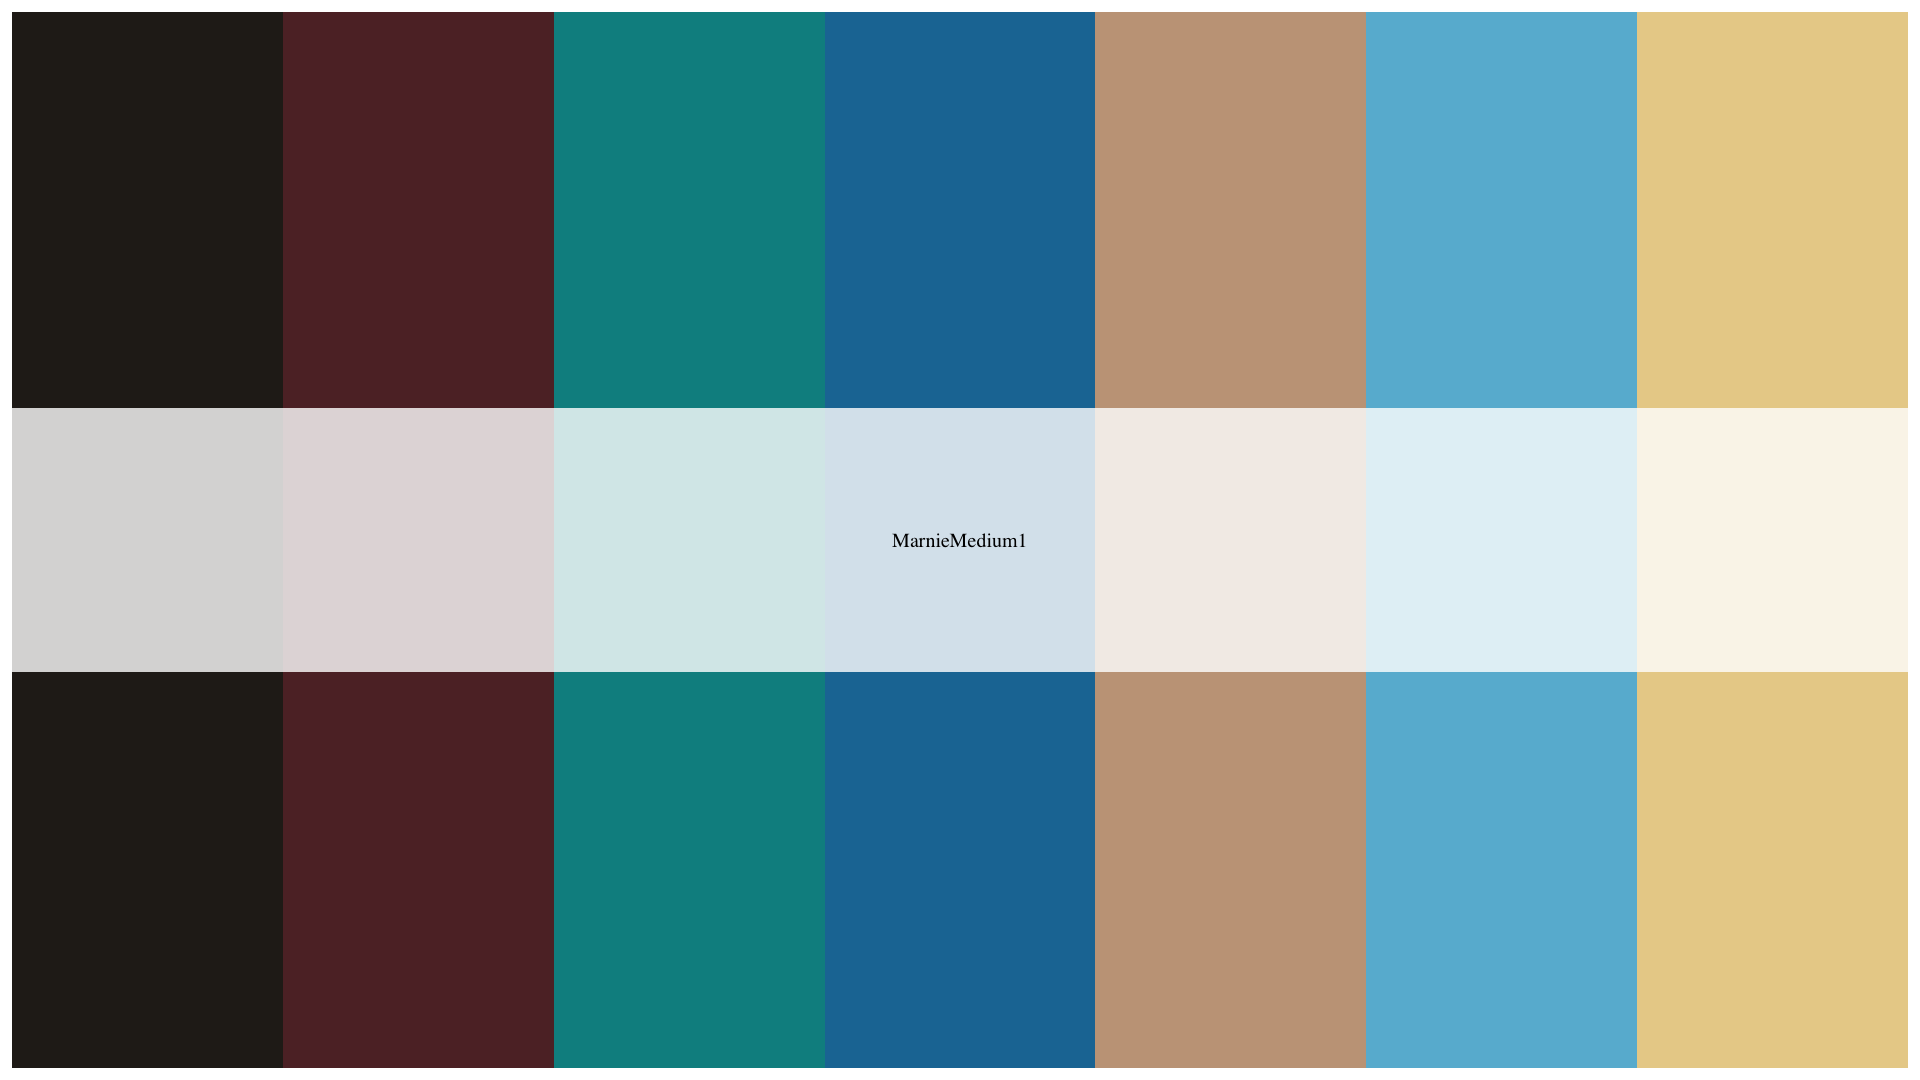

In [28]:
library(ghibli)
ghibli_palette("MarnieMedium1")

In [5]:
ghibli_palette("MarnieMedium1")[1:7]

[1] "#28231D" "#5E2D30" "#008E90" "#1C77A3" "#C5A387" "#67B8D6" "#E9D097"

## 获取分布信息熵

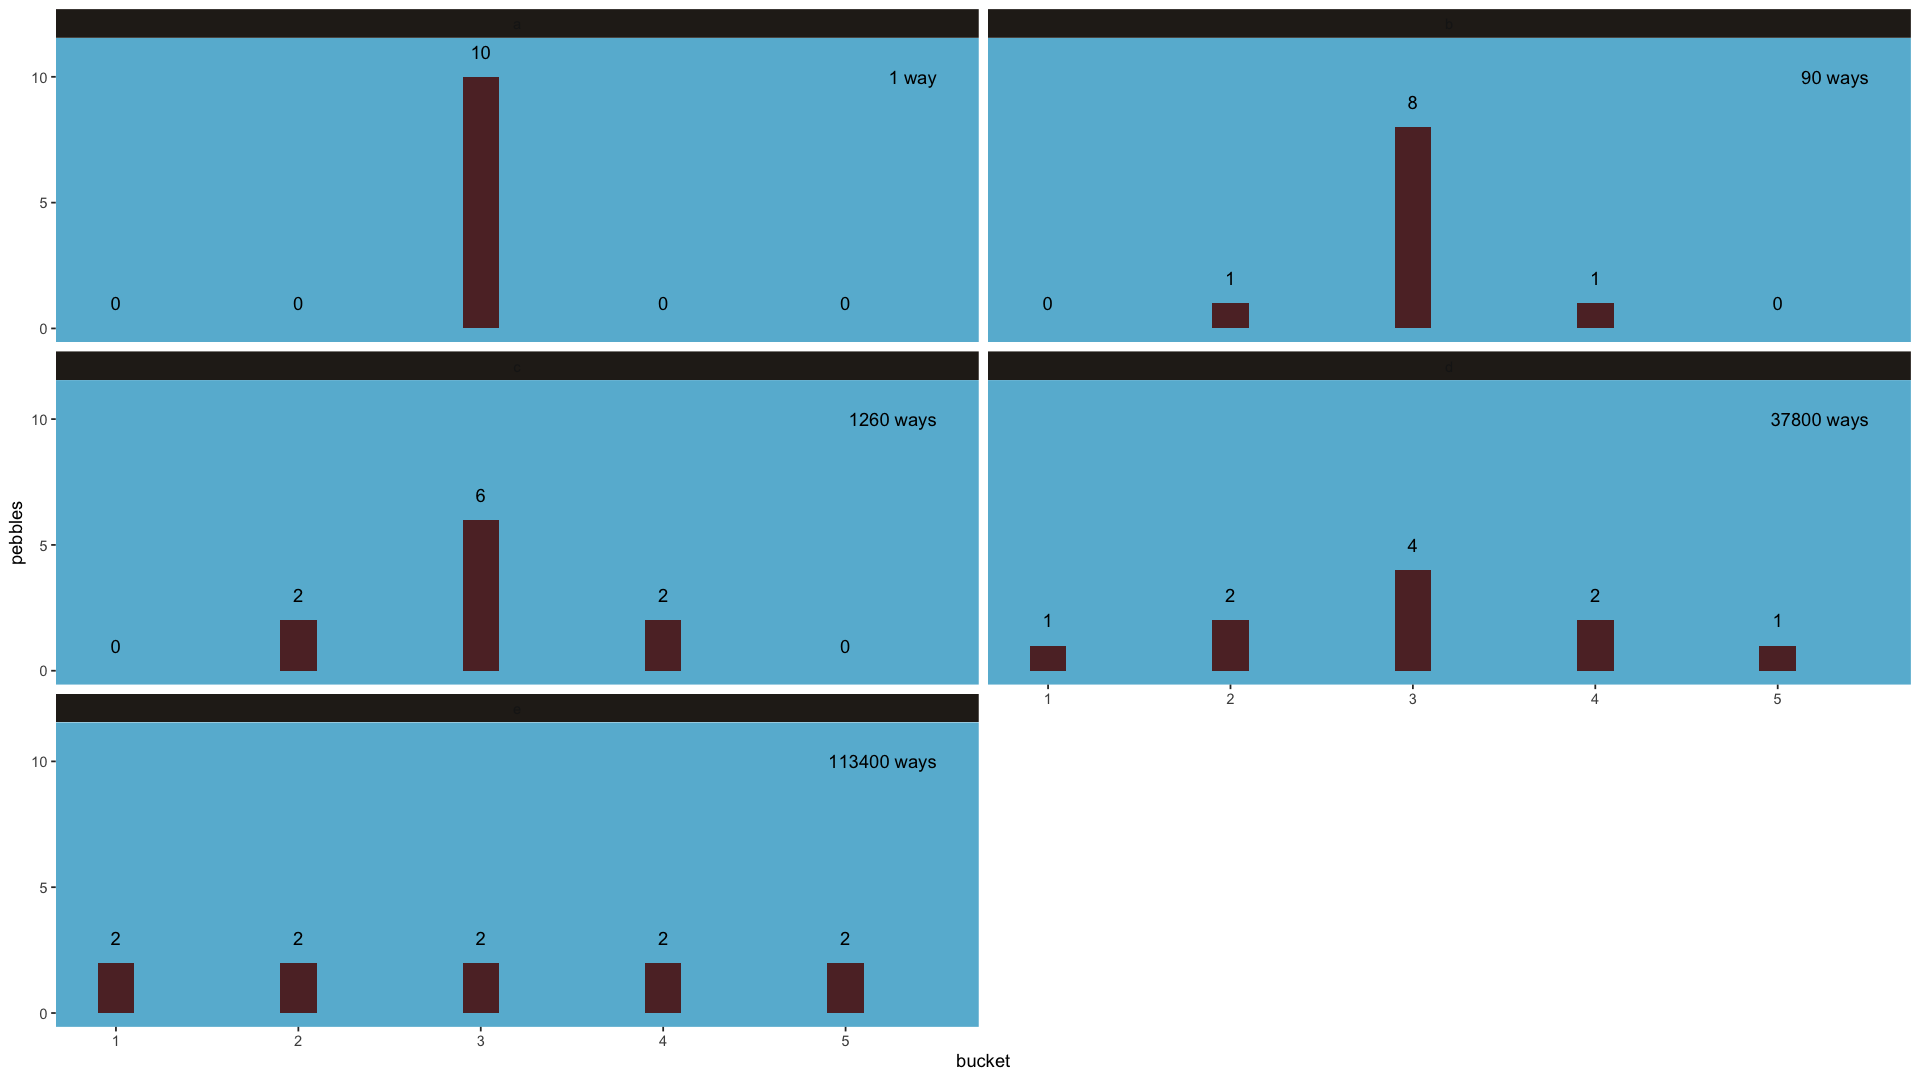

In [8]:
d %>% 
  mutate(bucket = 1:5) %>% 
  gather(letter, pebbles, - bucket) %>% 
  
  ggplot(aes(x = bucket, y = pebbles)) +
  geom_col(width = 1/5, fill = ghibli_palette("MarnieMedium1")[2]) +
  geom_text(aes(y = pebbles + 1, label = pebbles)) +
  geom_text(data = tibble(
    letter  = letters[1:5],
    bucket  = 5.5,
    pebbles = 10,
    label   = str_c(c(1, 90, 1260, 37800, 113400), 
                    rep(c(" way", " ways"), times = c(1, 4)))),
    aes(label = label), hjust = 1) +
  scale_y_continuous(breaks = c(0, 5, 10)) +
  theme(panel.grid = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("MarnieMedium1")[6]),
        strip.background = element_rect(fill = ghibli_palette("MarnieMedium1")[1])) +
  facet_wrap(~letter, ncol = 2)

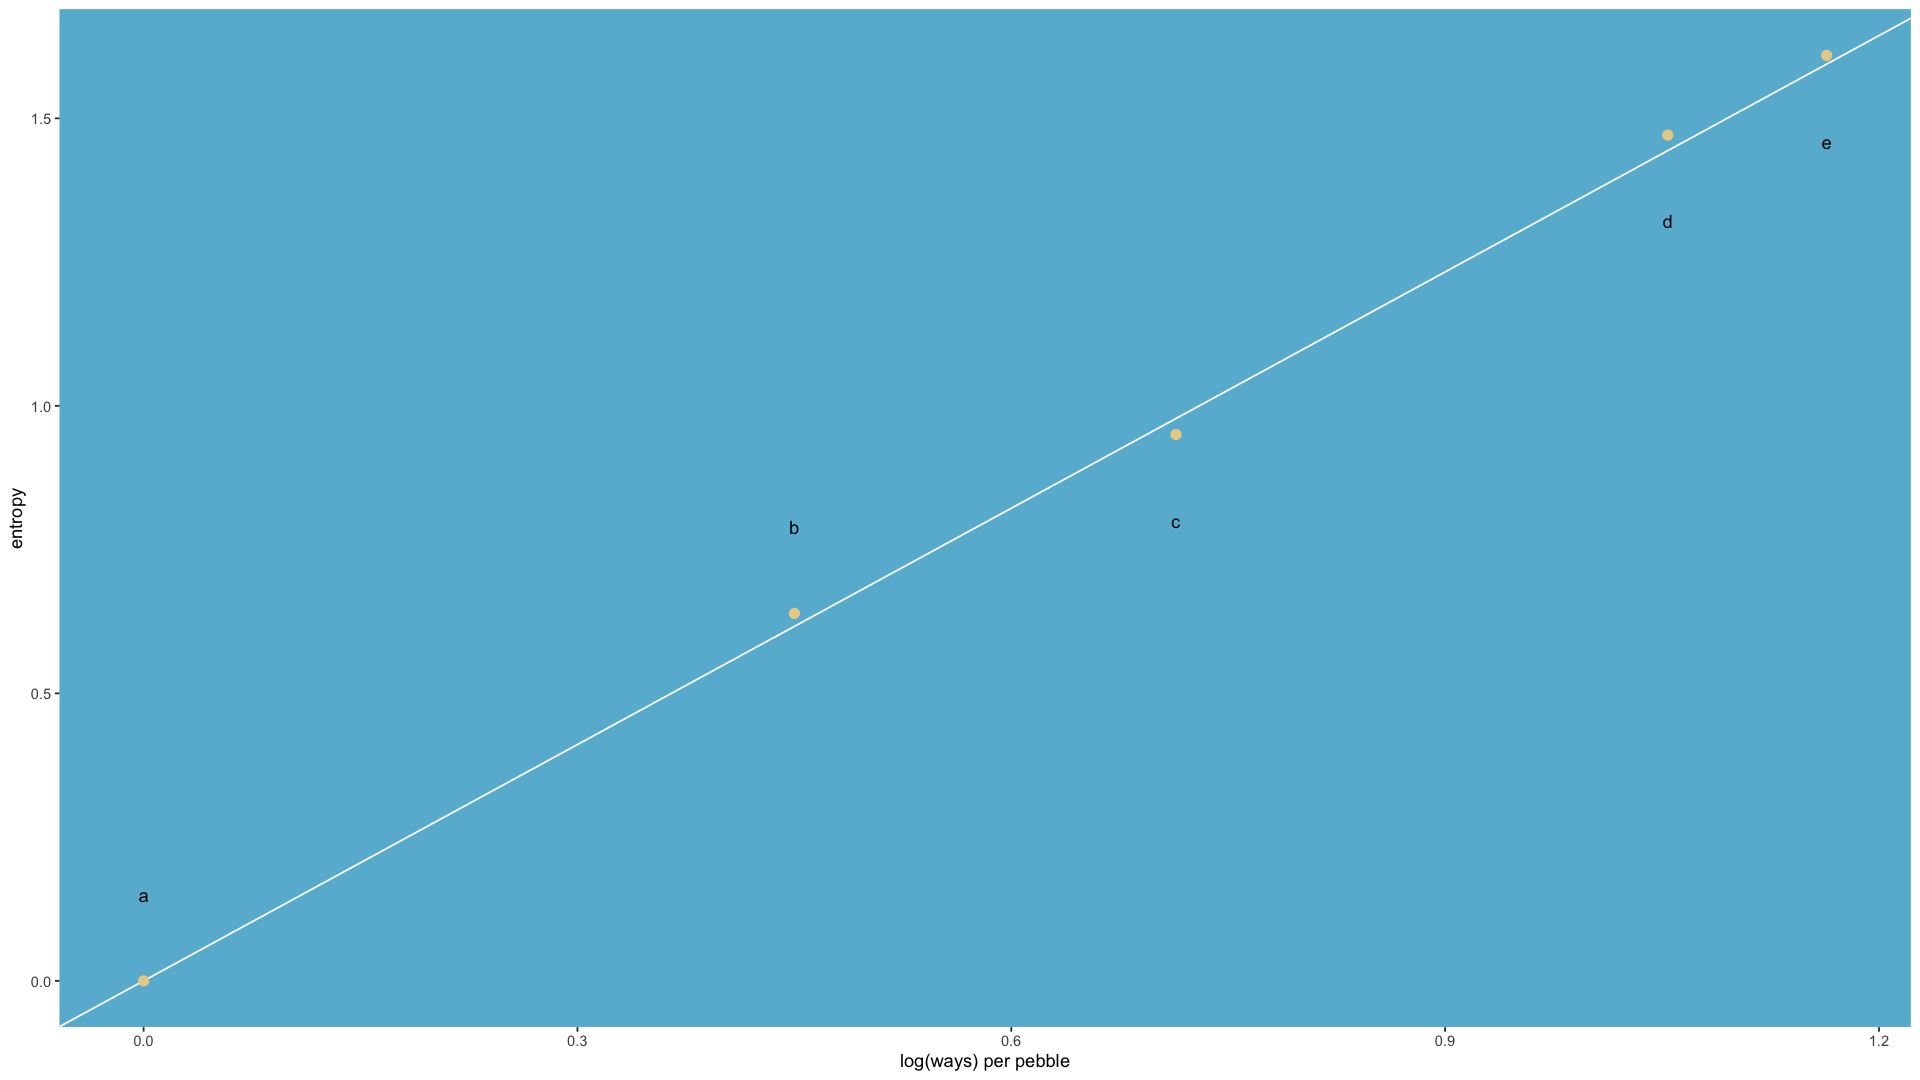

In [9]:
d %>% 
  # the next four lines are the same from above
  mutate_all(~ . / sum(.)) %>% 
  gather() %>% 
  group_by(key) %>% 
  summarise(h = -sum(ifelse(value == 0, 0, value * log(value)))) %>% 
  # here's the R code 9.4 stuff
  mutate(n_ways   = c(1, 90, 1260, 37800, 113400)) %>% 
  group_by(key) %>% 
  mutate(log_ways = log(n_ways) / 10,
         text_y   = ifelse(key < "c", h + .15, h - .15)) %>%
  
  # plot
  ggplot(aes(x = log_ways, y = h)) +
  geom_abline(intercept = 0, slope = 1.37, 
              color = "white") +
  geom_point(size = 2.5, color = ghibli_palette("MarnieMedium1")[7]) +
  geom_text(aes(y = text_y, label = key)) +
  labs(x = "log(ways) per pebble",
       y = "entropy") +
  theme(panel.grid = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("MarnieMedium1")[6]))


## 高斯分布

### 广义正态分布
- 概率密度(PDF)：
$$\operatorname{Pr}(y | \mu, \alpha, \beta)=\frac{\beta}{2 \alpha \Gamma\left(\frac{1}{\beta}\right)} e^{-\left(\frac{|y-\mu|}{\alpha}\right)^{\beta}}$$  
本例中$\alpha=\beta=\mu=\Gamma=\sigma^{2}=1 \sigma^{2} \neq \alpha \sigma$，即：
$$\sigma^{2}=\frac{\alpha^{2} \Gamma(3 / \beta)}{\Gamma(1 / \beta)}\Rightarrow \alpha=\sqrt{\frac{\sigma^{2} \Gamma(1 / \beta)}{\Gamma(3 / \beta)}}$$

In [52]:
beta     = c(1, 1.5, 2, 4)
ifelse(beta == 2, 'white', 'yellow')

[1] "yellow" "yellow" "white"  "yellow"

Warning message:
“Removed 80 row(s) containing missing values (geom_path).”
Warning message:
“Removed 6 row(s) containing missing values (geom_path).”


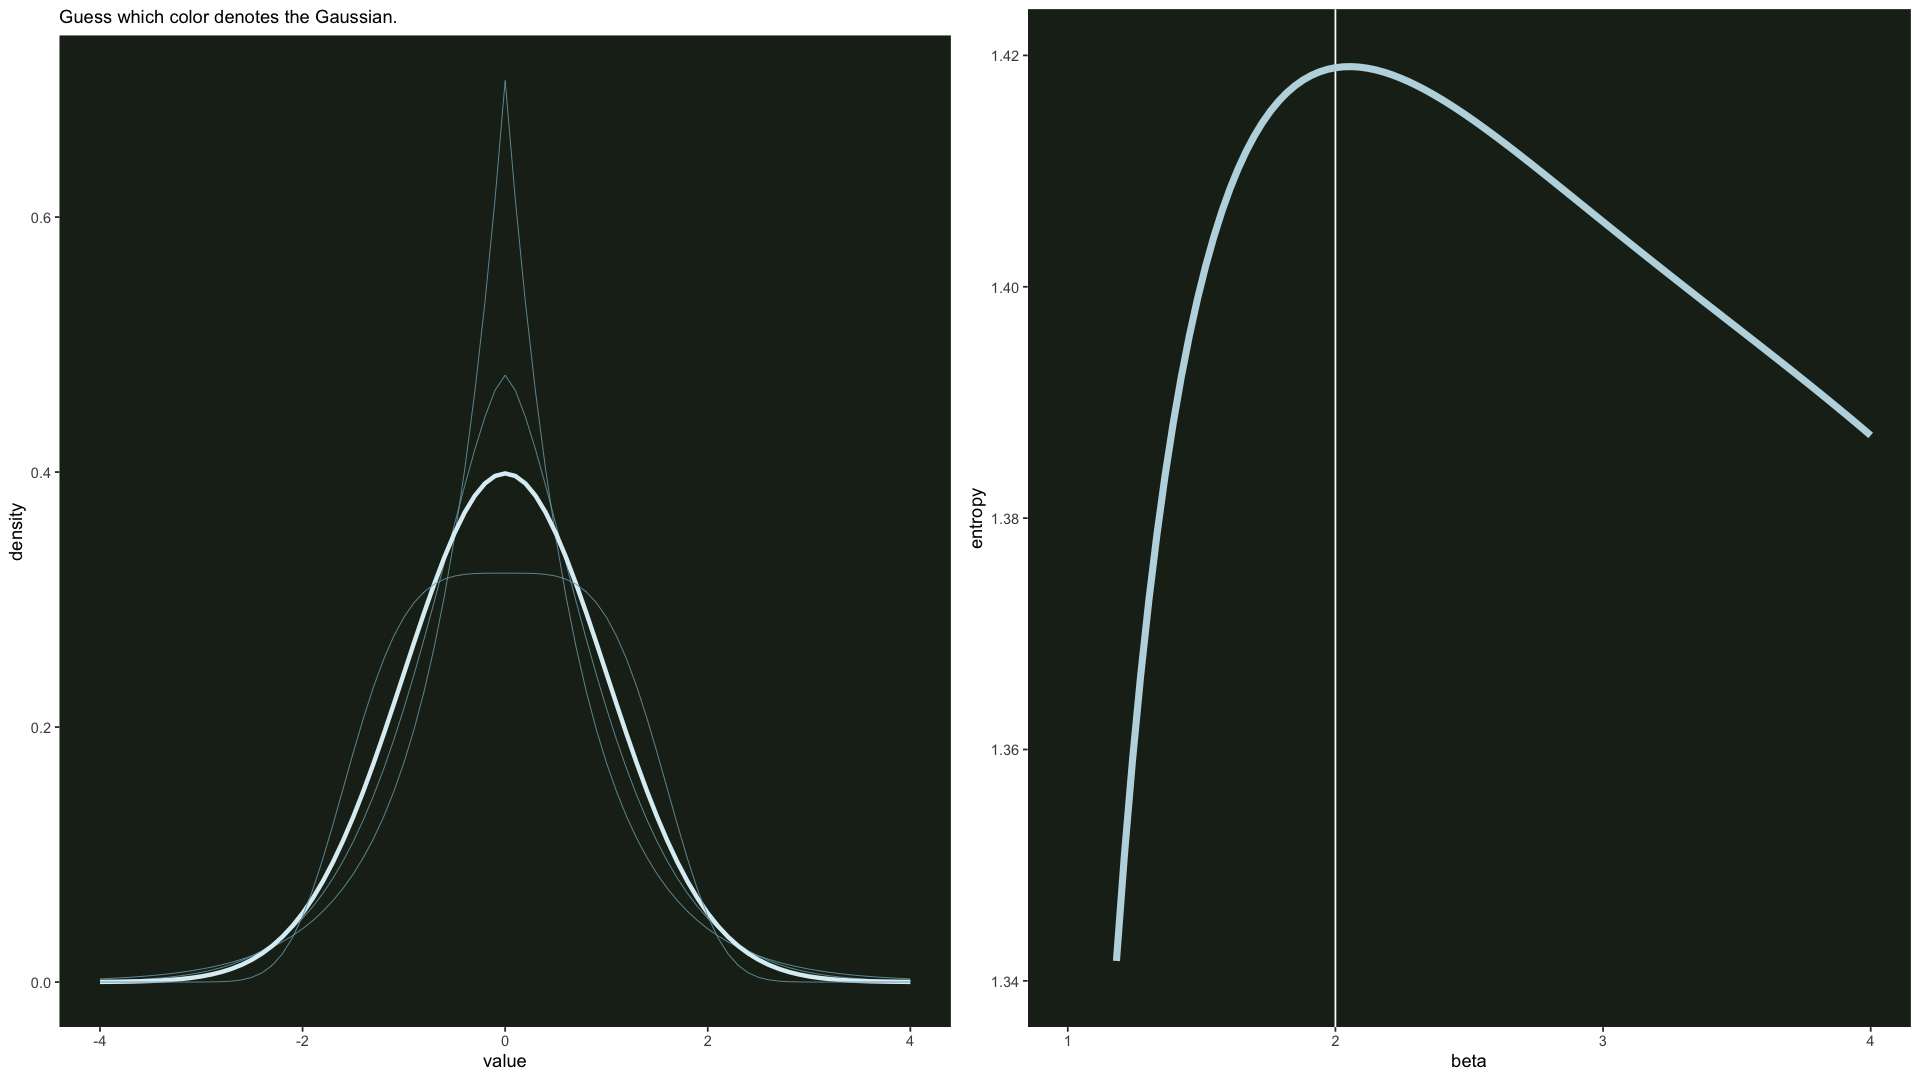

In [75]:
# 根据给定sigma、beta值计算alpha
alpha_per_beta <- function(variance, beta){
  sqrt((variance * gamma(1 / beta)) / gamma(3 / beta))
}

p1 = tibble(mu       = 0,
       variance = 1,    # 变异为1
       # I arrived at these values by trial and error
       beta     = c(1, 1.5, 2, 4)) %>% 
  mutate(alpha  = map2(variance, beta, alpha_per_beta)) %>% 
  unnest(cols = c(alpha)) %>% 
  expand(nesting(mu, beta, alpha), 
         value = seq(from = -5, to = 5, by = .1)) %>% 
  # behold the formula for the generalized normal distribution in code
  mutate(density = (beta / (2 * alpha * gamma(1 / beta))) * 
           exp(1) ^ (-1 * (abs(value - mu) / alpha) ^ beta)) %>% 
  
  # plot
  ggplot(aes(x = value, y = density,
             group = beta)) +
  geom_line(aes(color = beta == 2,    #给 beta = 2 的分布上色
                size  = beta == 2)) +
  scale_color_manual(values = c('#76A2AF',
                                '#DCEFF5')) +
  scale_size_manual(values = c(1/4, 1.25)) +
  ggtitle(NULL, subtitle = "Guess which color denotes the Gaussian.") +
  scale_x_continuous(limits = c(-4, 4)) +
  theme(panel.grid       = element_blank(),
        legend.position  = "none",
        panel.background = element_rect(fill = ghibli_palette("MarnieMedium2")[1]))

p2 = tibble(mu       = 0,
       variance = 1,
       # this time we need a more densely-packed sequence of `beta` values
       beta     = seq(from = 1, to = 4, length.out = 100)) %>% 
  mutate(alpha  = map2(variance, beta, alpha_per_beta)) %>%
  unnest(cols = c(alpha)) %>%
  expand(nesting(mu, beta, alpha), 
         value = -8:8) %>% 
  mutate(density = (beta / (2 * alpha * gamma(1 / beta))) * 
           exp(1) ^ (-1 * (abs(value - mu) / alpha) ^ beta)) %>% 
  group_by(beta) %>% 
  # this is just an abbreviated version of the formula we used in our first code block
  summarise(entropy = -sum(density * log(density))) %>% 
  
  ggplot(aes(x = beta, y = entropy)) +
  geom_vline(xintercept = 2, color = "white") +
  geom_line(size = 2, color = '#BCD9E1') +
  scale_y_continuous(limits = c(1.34, 1.42)) +
  theme(panel.grid       = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("MarnieMedium2")[1]))

cowplot::plot_grid(p1, p2, ncol = 2)

## 二项分布
$$\operatorname{Pr}\left(y_{1}, y_{2}, \ldots, y_{n} | n, p\right)=p^{y}(1-p)^{n-y}$$
考虑以下试次：\begin{array}{l}\cdot 0,0,0,0(\text { i.e., } n=4 \text { and } y=0) \\ \cdot 1,0,0,0(\text { i.e., } n=4 \text { and } y=1) \\ \cdot 1,1,0,0(\text { (i.e., } n=4 \text { and } y=2)\end{array}

In [78]:
count_ways <- function(n, y){
  # n ：总试次 (i.e., the number of rows in your vector)
  # y ：1试次出现次数 (i.e., successes)
  (factorial(n) / (factorial(y) * factorial(n - y)))
}

tibble(sequence = 1:3,
       n        = 4,
       y        = c(0, 1, 2)) %>% 
  mutate(n_ways = map2(n, y, count_ways)) %>% 
  unnest(cols = c(n_ways))

sequence,n,y,n_ways
<int>,<dbl>,<dbl>,<dbl>
1,4,0,1
2,4,1,4
3,4,2,6


In [79]:
(
  d <-
  tibble(distribution = letters[1:4],
         ww = c(1/4, 2/6, 1/6, 1/8),
         bw = c(1/4, 1/6, 2/6, 4/8),
         wb = c(1/4, 1/6, 2/6, 2/8),
         bb = c(1/4, 2/6, 1/6, 1/8))
  )

distribution,ww,bw,wb,bb
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.2500000,0.2500000,0.2500000,0.2500000
b,0.3333333,0.1666667,0.1666667,0.3333333
c,0.1666667,0.3333333,0.3333333,0.1666667
d,0.1250000,0.5000000,0.2500000,0.1250000


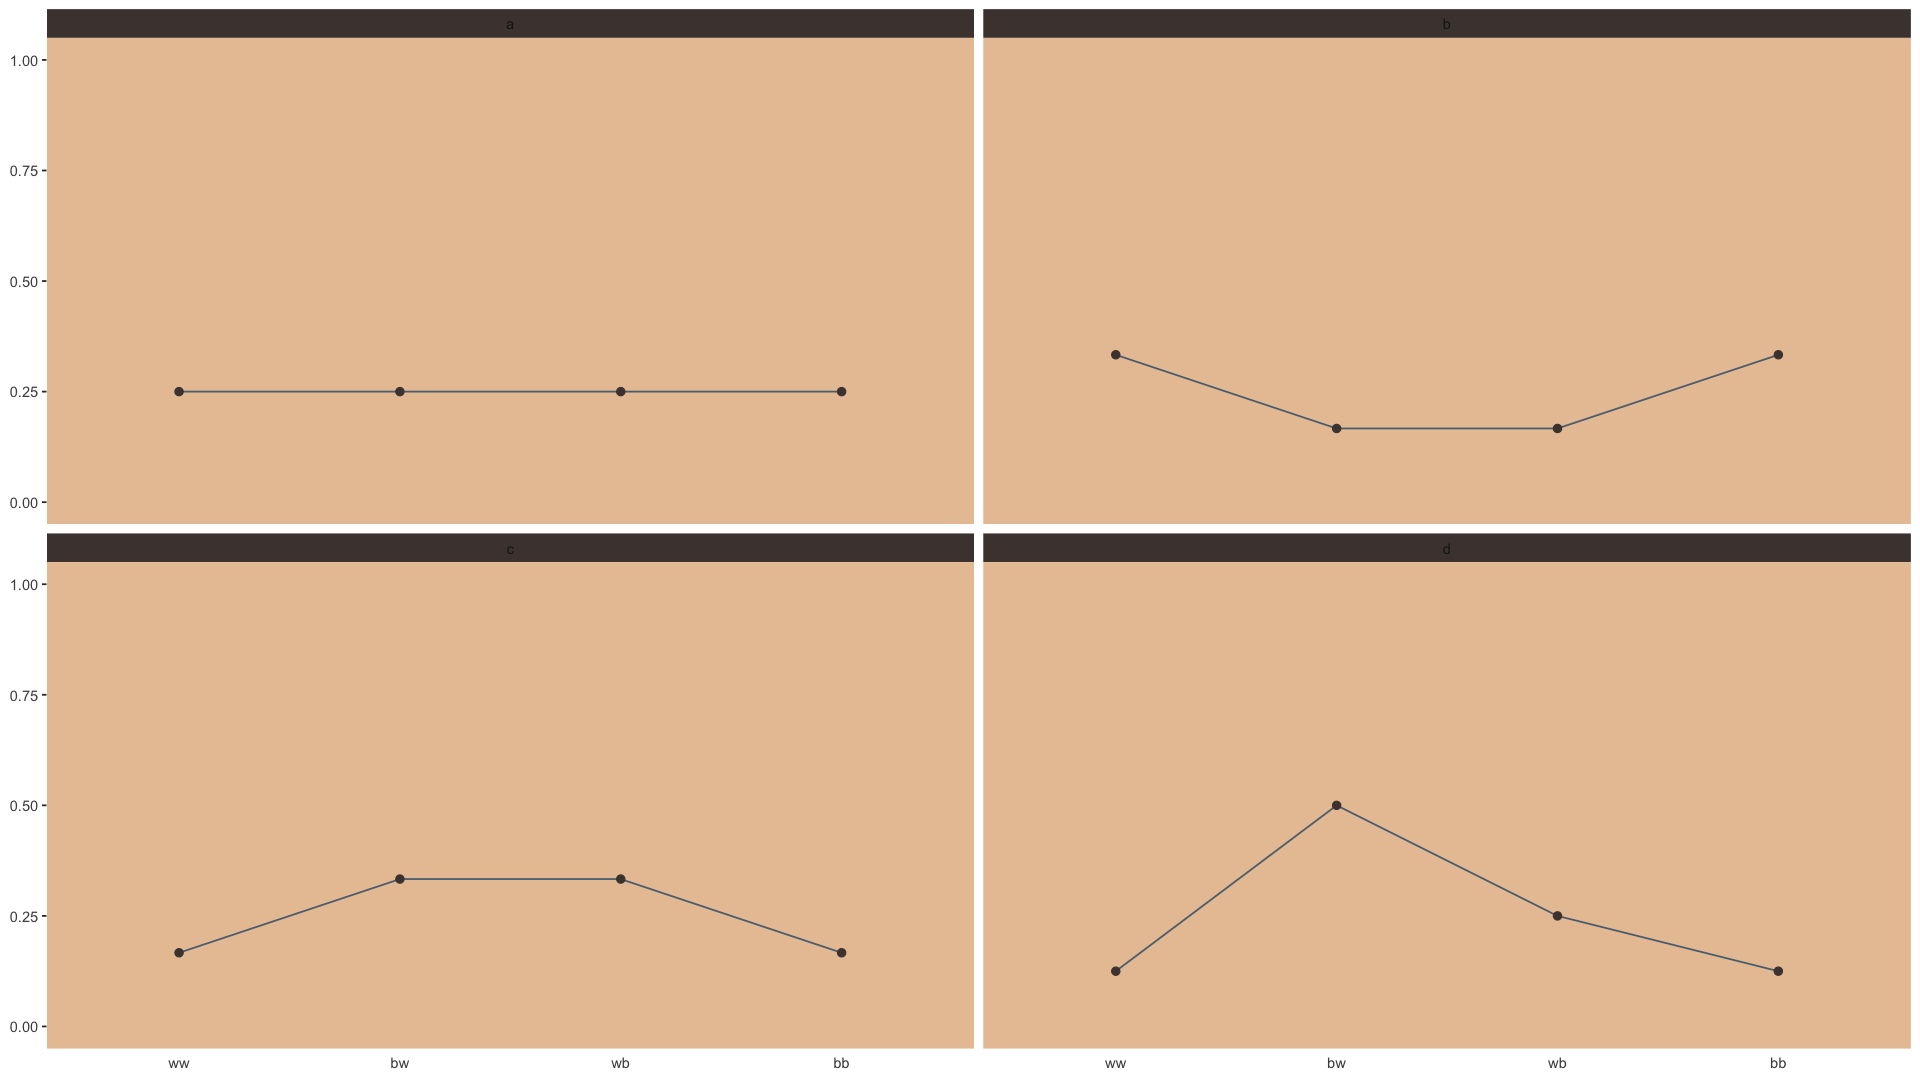

In [110]:
d %>% 
  gather(key, value, -distribution) %>% 
  mutate(key = factor(key, levels = c("ww", "bw", "wb", "bb"))) %>% 
  
  ggplot(aes(x = key, y = value, group = 1)) +
  geom_line(color = ghibli_palette("PonyoMedium")[2]) +
  geom_point(size = 2, color = ghibli_palette("PonyoMedium")[1]) +
  coord_cartesian(ylim = 0:1) +
  labs(x = NULL,
       y = NULL) +
  theme(panel.grid   = element_blank(),
        axis.ticks.x = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("PonyoMedium")[7]),
        strip.background = element_rect(fill = ghibli_palette("PonyoMedium")[1])) +
  facet_wrap(~distribution)

In [111]:
d %>% 
  gather(sequence, probability, -distribution) %>% 
  # `str_count()` will count the number of times "b" occurs within a given row of `sequence`
  mutate(n_b     = str_count(sequence, "b")) %>% 
  mutate(product = probability * n_b) %>% 
  group_by(distribution) %>% 
  summarise(expected_value = sum(product))

distribution,expected_value
<chr>,<dbl>
a,1
b,1
c,1
d,1


### 计算分布熵

In [112]:
d %>% 
  gather(sequence, probability, -distribution) %>% 
  group_by(distribution) %>% 
  summarise(entropy = -sum(probability * log(probability)))

distribution,entropy
<chr>,<dbl>
a,1.386294
b,1.329661
c,1.329661
d,1.213008


### 改变期望后的熵分布

In [113]:
p <- 0.7

(
  a <- 
  c((1 - p)^2, 
    p * (1 - p), 
    (1 - p) * p, 
    p^2)
)

[1] 0.09 0.21 0.21 0.49

In [114]:
-sum(a * log(a))

[1] 1.221729

In [115]:
sim_p <- function(seed, g = 1.4) {
  
  set.seed(seed)
  
  x_123 <- runif(3)
  x_4   <- ((g) * sum(x_123) - x_123[2] - x_123[3]) / (2 - g)
  z     <- sum(c(x_123, x_4))
  p     <- c(x_123, x_4) / z
  tibble(h   = -sum(p * log(p)), 
         p   = p,
         key = factor(c("ww", "bw", "wb", "bb"), levels = c("ww", "bw", "wb", "bb")))
}

sim_p(seed = 9.9, g = 1.4)

h,p,key
<dbl>,<dbl>,<fct>
1.022354,0.19710875,ww
1.022354,0.02155544,bw
1.022354,0.18422705,wb
1.022354,0.59710875,bb


### 期望模拟

In [124]:
# how many replications would you like?
n_rep <- 1e5

d <-
  tibble(seed = 1:n_rep) %>% 
  mutate(sim = map2(seed, 1.4, sim_p)) %>% 
  unnest(cols = c(sim))

head(d)

seed,h,p,key
<int>,<dbl>,<dbl>,<fct>
1,1.209417,0.10793075,ww
1,1.209417,0.15127043,bw
1,1.209417,0.23286807,wb
1,1.209417,0.50793075,bb
2,1.213364,0.06741521,ww
2,1.213364,0.25611268,bw


In [120]:
ranked_d <-
  d %>% 
  group_by(seed) %>% 
  arrange(desc(h)) %>% 
  ungroup() %>%
  # here's the rank order step
  mutate(rank = rep(1:n_rep, each = 4))

head(ranked_d)

seed,h,p,key,rank
<int>,<dbl>,<dbl>,<fct>,<int>
55665,1.221727,0.09029279,ww,1
55665,1.221727,0.20948582,bw,1
55665,1.221727,0.20992860,wb,1
55665,1.221727,0.49029279,bb,1
71132,1.221727,0.09018922,ww,2
71132,1.221727,0.21030584,bw,2


In [118]:
subset_d <-
  ranked_d %>%
  # I arrived at these `rank` values by trial and error
  filter(rank %in% c(1, 87373, n_rep - 1500, n_rep - 10)) %>% 
  # I arrived at the `height` values by trial and error, too
  mutate(height       = rep(c(8, 2.25, .75, .5), each = 4),
         distribution = rep(letters[1:4], each = 4))

head(subset_d)

seed,h,p,key,rank,height,distribution
<int>,<dbl>,<dbl>,<fct>,<int>,<dbl>,<chr>
55665,1.2217274,0.09029279,ww,1,8.00,a
55665,1.2217274,0.20948582,bw,1,8.00,a
55665,1.2217274,0.20992860,wb,1,8.00,a
55665,1.2217274,0.49029279,bb,1,8.00,a
50981,0.9998461,0.04592120,ww,87373,2.25,b
50981,0.9998461,0.04594962,bw,87373,2.25,b


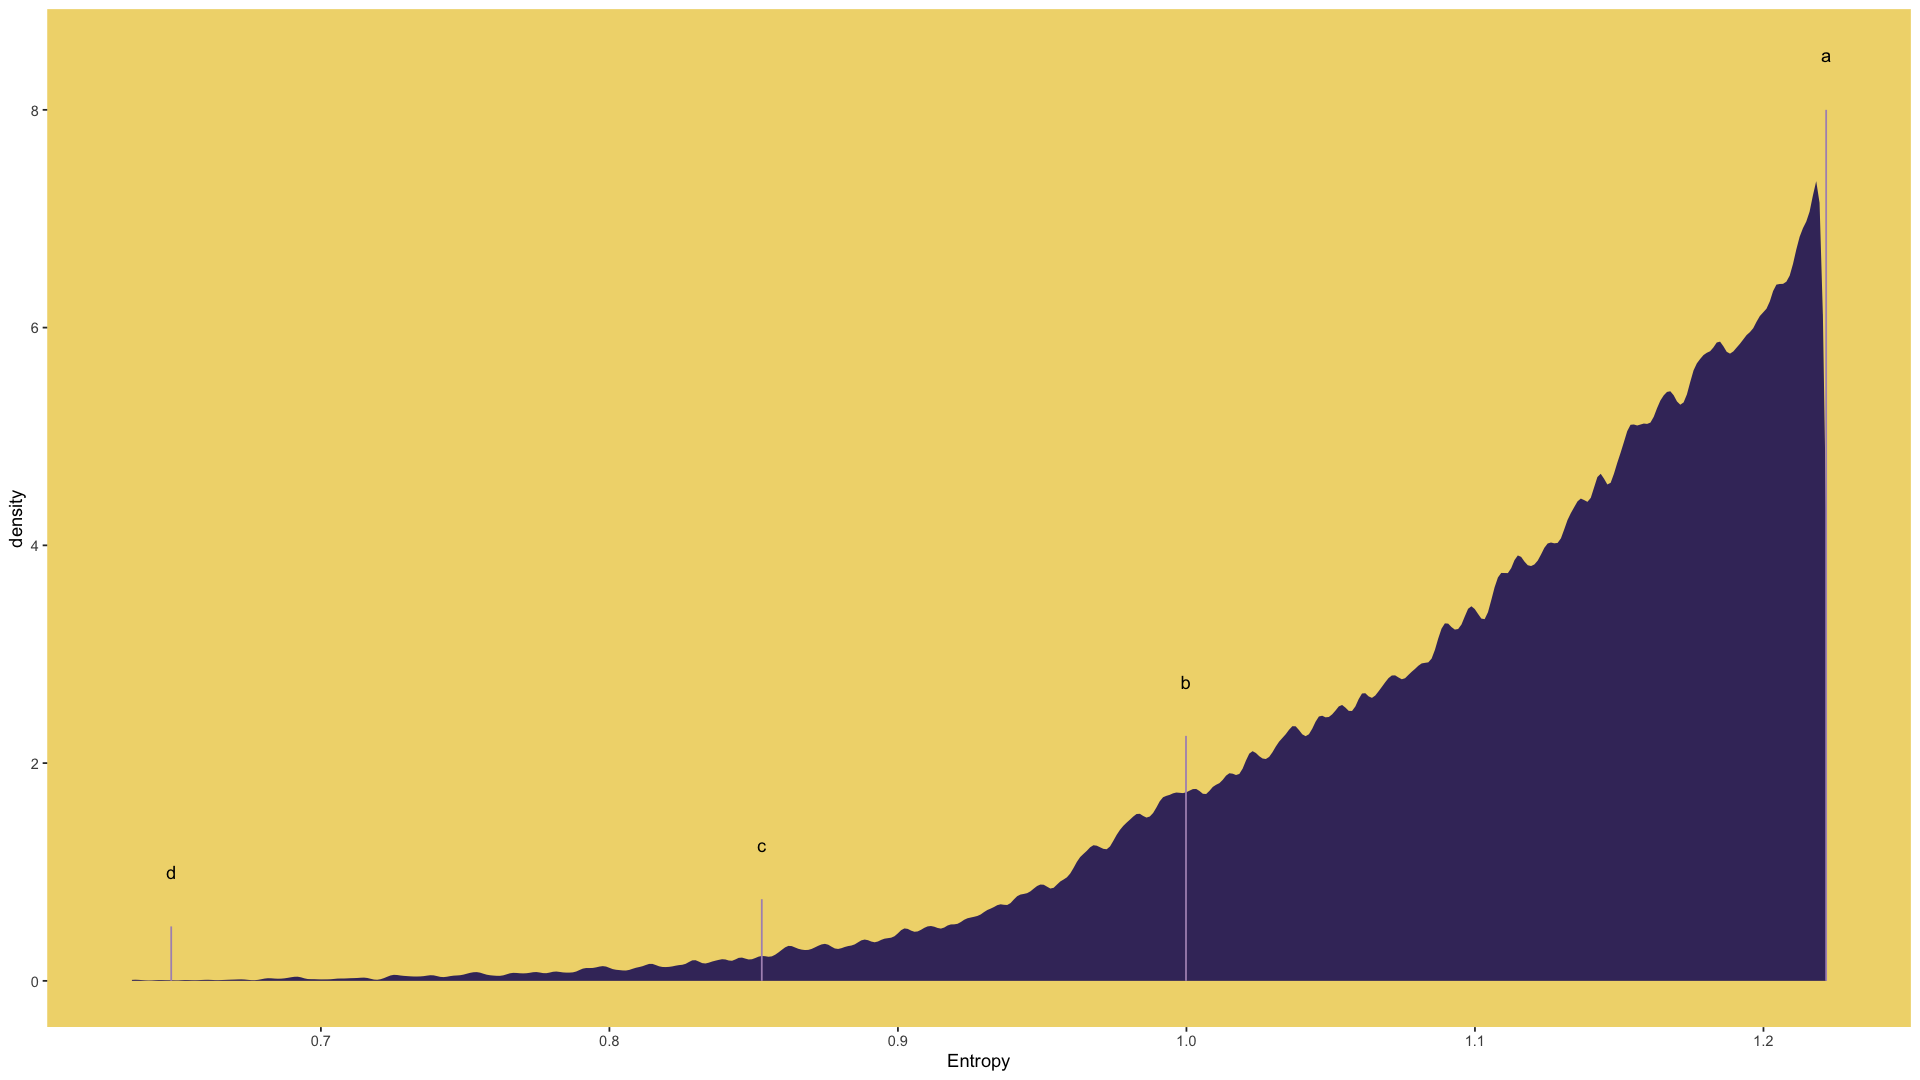

In [121]:
d %>% 
  ggplot(aes(x = h)) +
  geom_density(size = 0, fill = ghibli_palette("LaputaMedium")[3],
               adjust = 1/4) +
  # note the data statements for the next two geoms
  geom_linerange(data = subset_d %>% group_by(seed) %>% slice(1),
                 aes(ymin = 0, ymax = height),
                 color = ghibli_palette("LaputaMedium")[5]) +
  geom_text(data = subset_d %>% group_by(seed) %>% slice(1),
            aes(y = height + .5, label = distribution)) +
  scale_x_continuous("Entropy",
                     breaks = seq(from = .7, to = 1.2, by = .1)) +
  theme(panel.grid       = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("LaputaMedium")[7]))

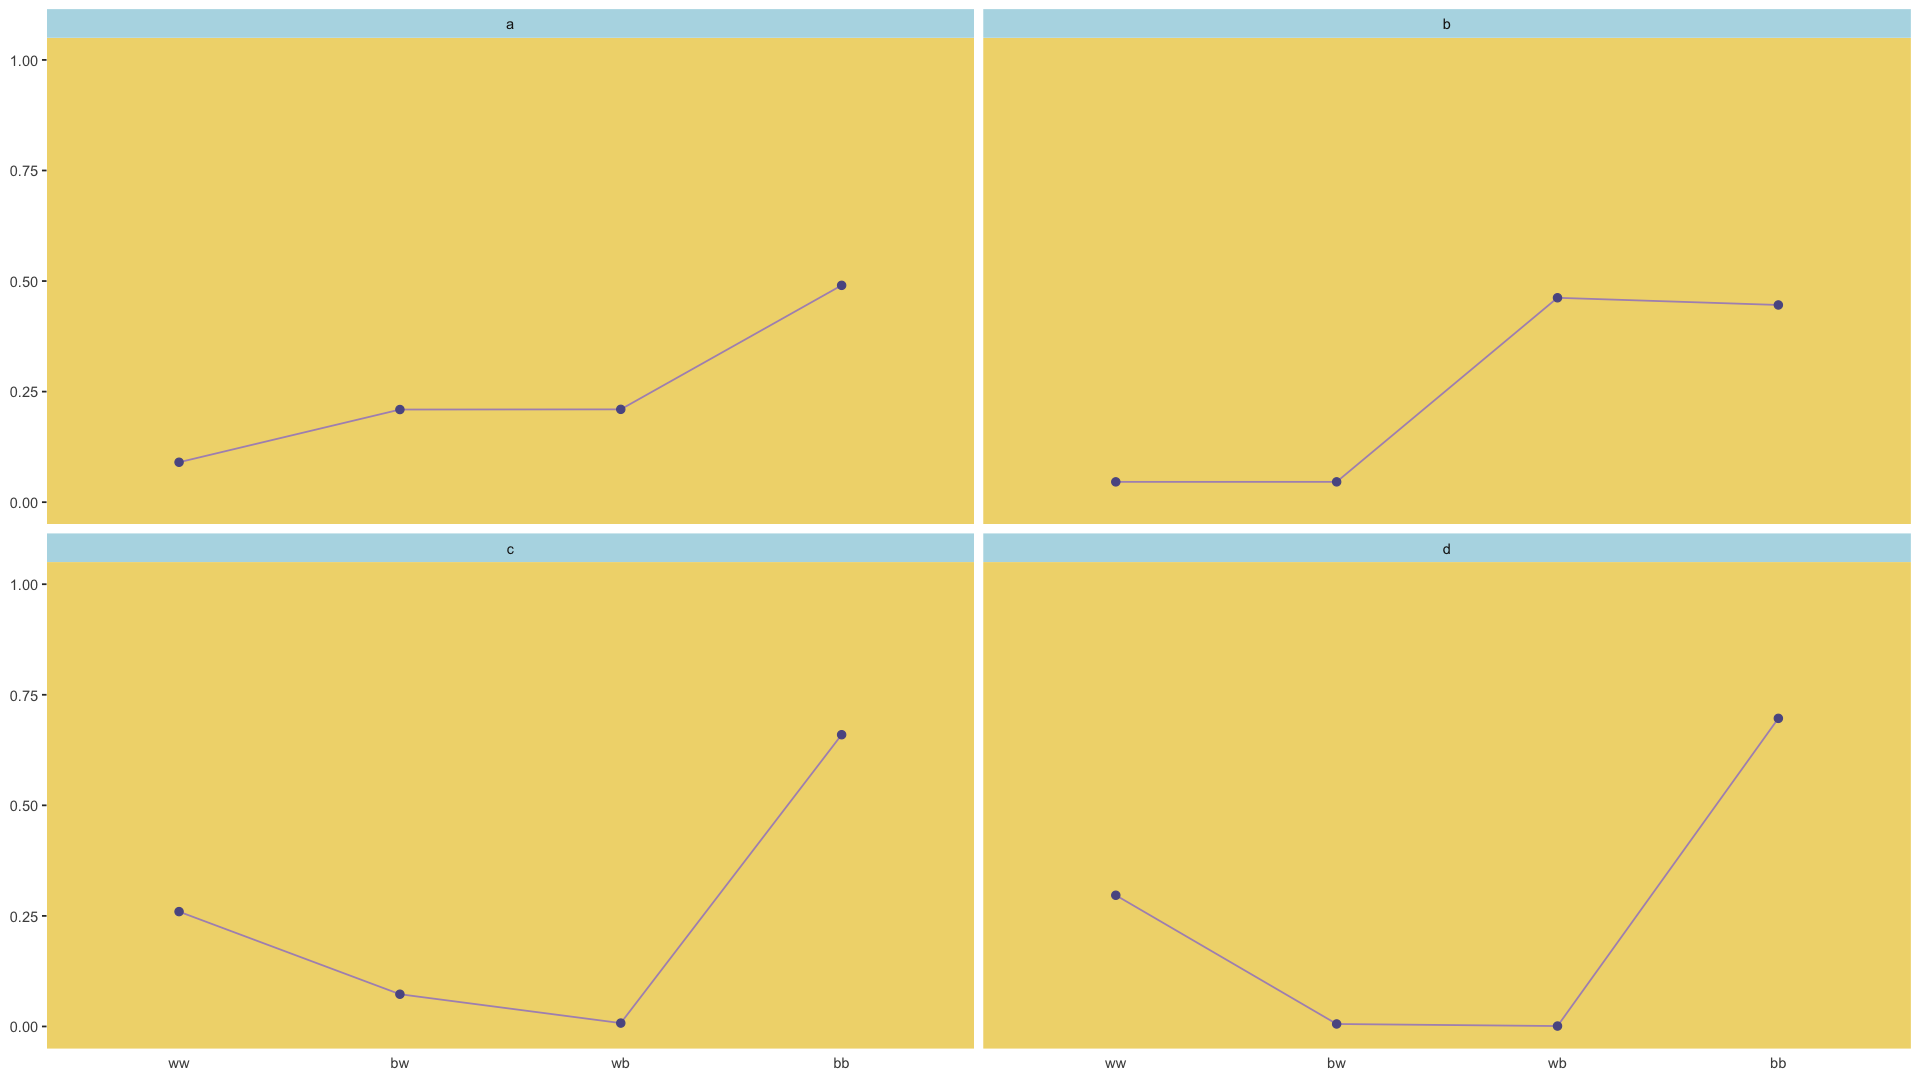

In [122]:
ranked_d %>%
  filter(rank %in% c(1, 87373, n_rep - 1500, n_rep - 10)) %>% 
  mutate(distribution = rep(letters[1:4], each = 4)) %>% 

  ggplot(aes(x = key, y = p, group = 1)) +
  geom_line(color = ghibli_palette("LaputaMedium")[5]) +
  geom_point(size = 2, color = ghibli_palette("LaputaMedium")[4]) +
  coord_cartesian(ylim = 0:1) +
  labs(x = NULL,
       y = NULL) +
  theme(panel.grid   = element_blank(),
        axis.ticks.x = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("LaputaMedium")[7]),
        strip.background = element_rect(fill = ghibli_palette("LaputaMedium")[6])) +
  facet_wrap(~distribution)

In [123]:
ranked_d %>% 
  group_by(key) %>% 
  slice(max(h))

seed,h,p,key,rank
<int>,<dbl>,<dbl>,<fct>,<int>
55665,1.221727,0.09029279,ww,1
55665,1.221727,0.20948582,bw,1
55665,1.221727,0.20992860,wb,1
55665,1.221727,0.49029279,bb,1


# GLM

Warning message:
“Removed 231 row(s) containing missing values (geom_path).”


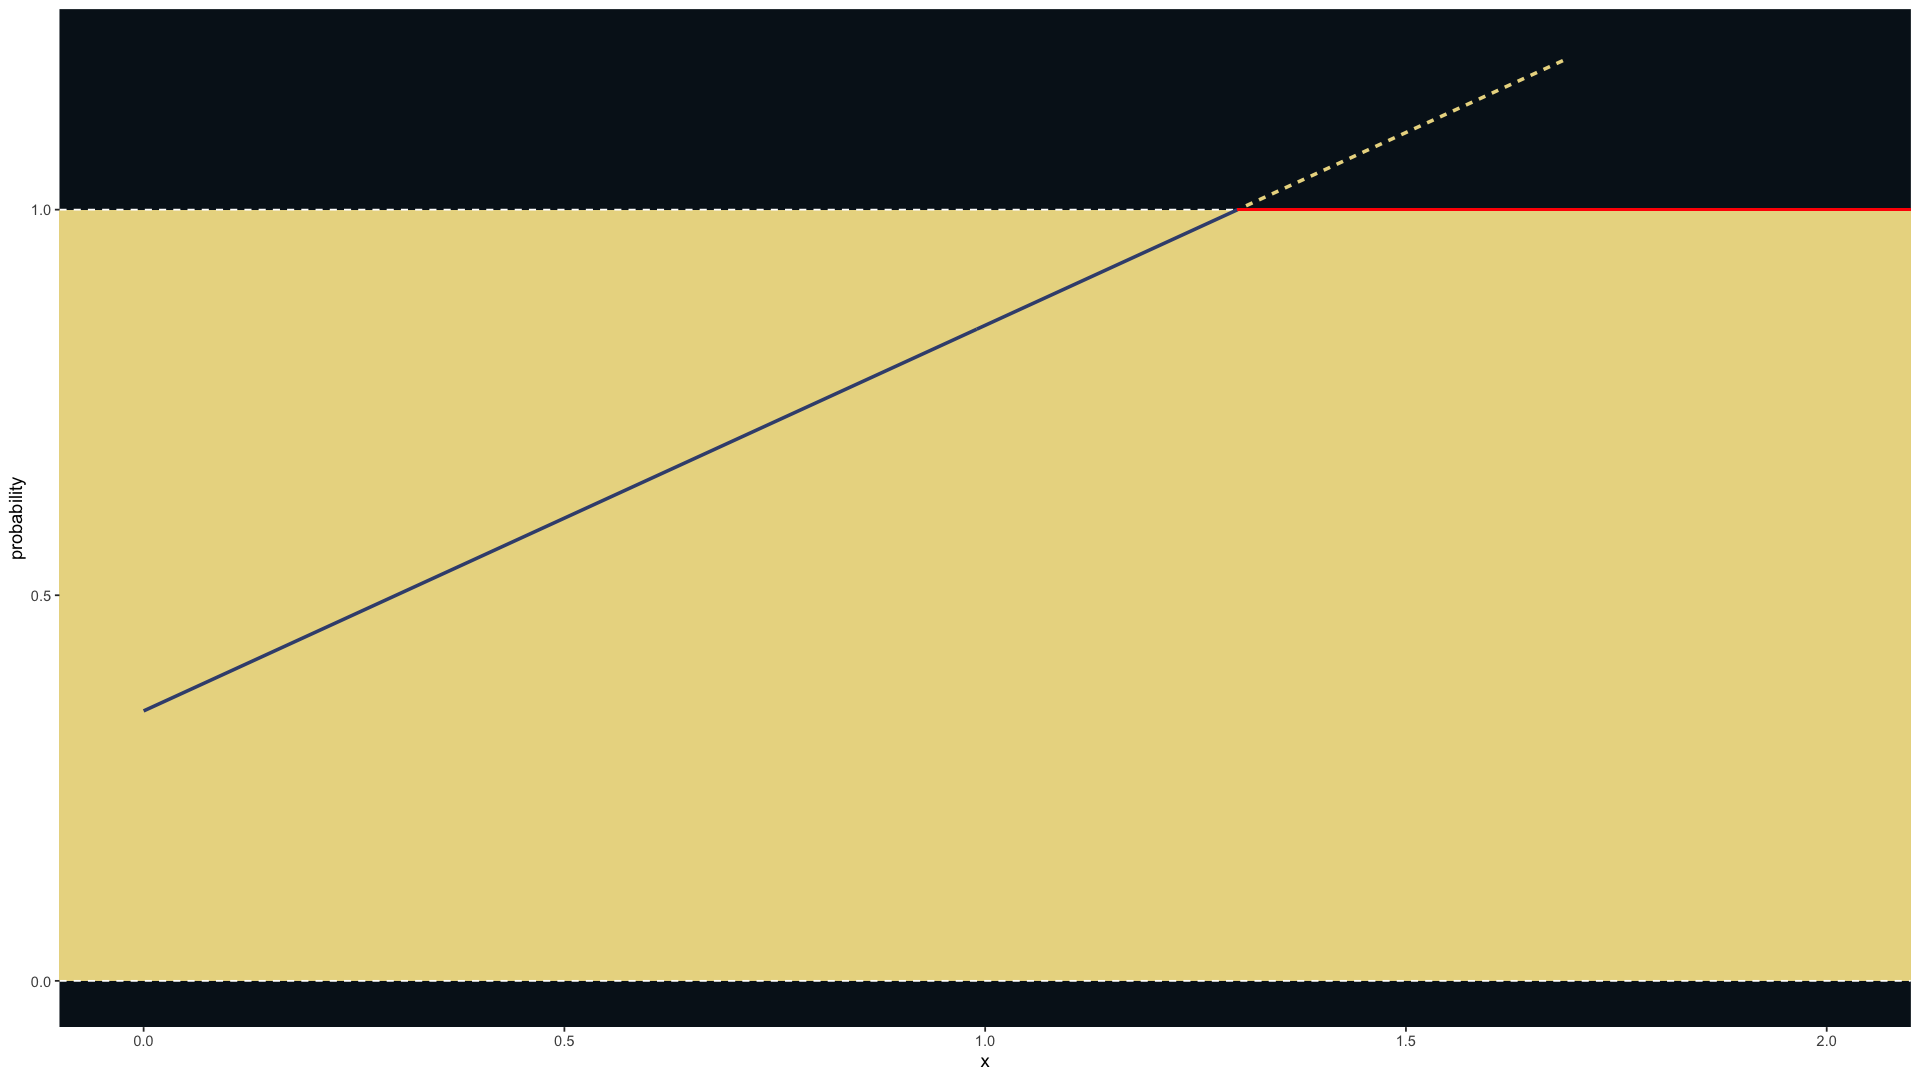

In [16]:
tibble(x = seq(from = -1, to = 3, by = .01)) %>%
  mutate(probability = .35 + x * .5) %>% 

  ggplot(aes(x = x, y = probability)) +
  geom_rect(xmin = -1, xmax = 3,
            ymin = 0,  ymax = 1,
            fill = ghibli_palette("MononokeMedium")[7]) +
  geom_hline(yintercept = 0:1, linetype = 2, color = 'white') +
  geom_line(aes(linetype = probability > 1, color = probability > 1),
            size = 1) +
  geom_segment(x = 1.3, xend = 3,
               y = 1, yend = 1,
               size = 2/3, color = 'red') +
  scale_color_manual(values = c(ghibli_palette("MononokeMedium")[3],
                                ghibli_palette("MononokeMedium")[7])) +
  scale_x_continuous(limits = c(0, 2)) +
  scale_y_continuous(limits = c(0, 1.2), breaks = c(0, .5, 1)) +
  theme(panel.grid       = element_blank(),
        legend.position  = "none",
        panel.background = element_rect(fill = ghibli_palette("MononokeMedium")[1]))

## 指数族分布

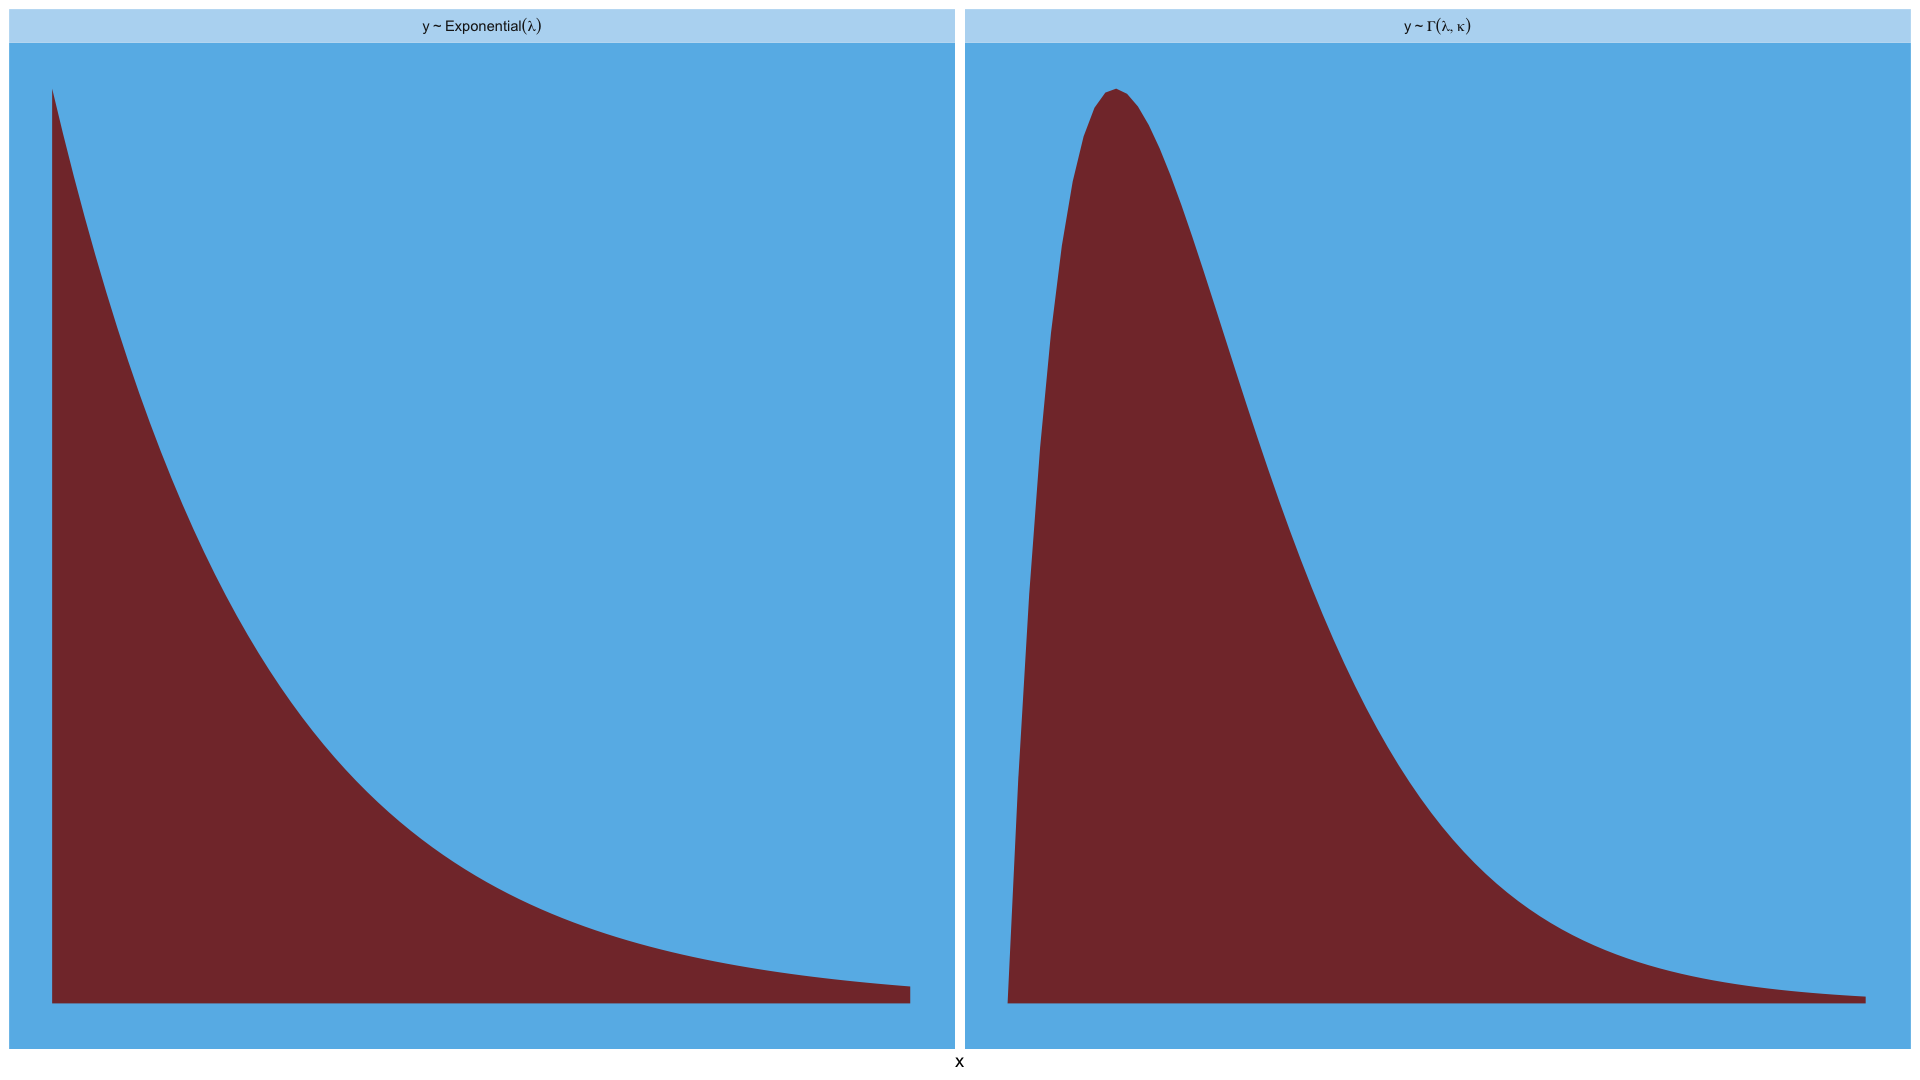

In [18]:
length_out <- 100

tibble(x = seq(from = 0, to = 5, length.out = length_out)) %>% 
  mutate(Gamma       = dgamma(x, 2, 2),
         Exponential = dexp(x)) %>% 
  gather(key, density, -x) %>% 
  mutate(label = rep(c("y %~% Gamma(lambda, kappa)", "y %~% Exponential(lambda)"), each = n()/2)) %>% 
  
  ggplot(aes(x = x, ymin = 0, ymax = density)) +
  geom_ribbon(fill = ghibli_palette("SpiritedMedium")[3]) +
  scale_x_continuous(limits = c(0, 4), breaks = NULL) +
  scale_y_continuous(NULL, breaks = NULL) +
  theme(panel.grid       = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("SpiritedMedium")[5]),
        strip.background = element_rect(fill = ghibli_palette("SpiritedMedium")[7])) +
  facet_wrap(~label, scales = "free_y", labeller = label_parsed)

Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 2 rows containing missing values (geom_col).”
Warning message:
“Removed 2 rows containing missing values (geom_col).”


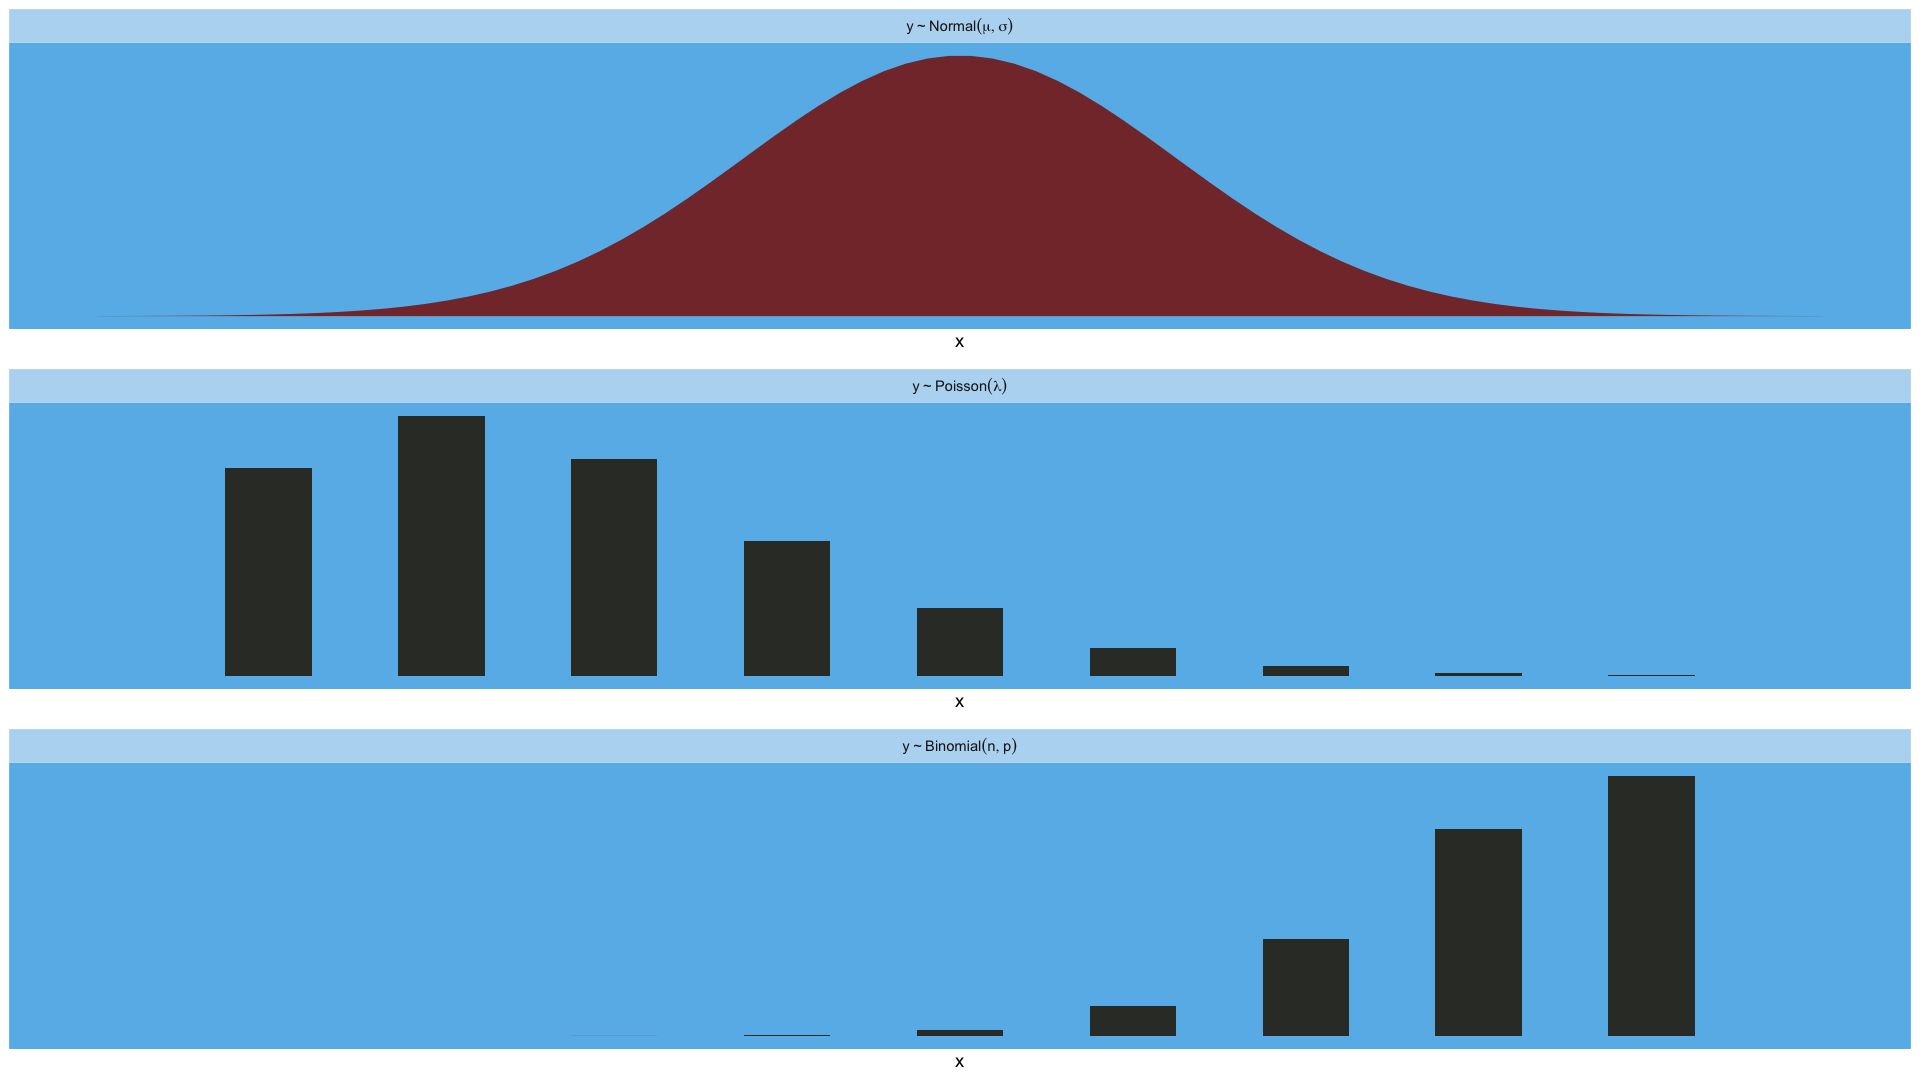

In [26]:
length_out <- 100

p5 = tibble(x = seq(from = -5, to = 5, length.out = length_out)) %>% 
  mutate(density = dnorm(x),
         strip   = "y %~% Normal(mu, sigma)") %>% 

  ggplot(aes(x = x, ymin = 0, ymax = density)) +
  geom_ribbon(fill = ghibli_palette("SpiritedMedium")[3]) +
  scale_x_continuous(limits = c(-4, 4), breaks = NULL) +
  scale_y_continuous(NULL, breaks = NULL) +
  theme(panel.grid       = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("SpiritedMedium")[5]),
        strip.background = element_rect(fill = ghibli_palette("SpiritedMedium")[7])) +
  facet_wrap(~strip, labeller = label_parsed)

p6 = tibble(x = 0:20) %>% 
  mutate(density = dpois(x, lambda = 2.5),
         strip   = "y %~% Poisson(lambda)") %>% 

  ggplot(aes(x = x, y = density)) +
  geom_col(fill = ghibli_palette("SpiritedMedium")[2], width = 1/2) +
  scale_x_continuous(limits = c(0, 10), breaks = NULL) +
  scale_y_continuous(NULL, breaks = NULL) +
  theme(panel.grid       = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("SpiritedMedium")[5]),
        strip.background = element_rect(fill = ghibli_palette("SpiritedMedium")[7])) +
  facet_wrap(~strip, labeller = label_parsed)

p7 = tibble(x = 0:10) %>% 
  mutate(density = dbinom(x, size = 10, prob = .85),
         strip   = "y %~% Binomial(n, p)") %>% 

  ggplot(aes(x = x, y = density)) +
  geom_col(fill = ghibli_palette("SpiritedMedium")[2], width = 1/2) +
  scale_x_continuous(limits = c(0, 10), breaks = NULL) +
  scale_y_continuous(NULL, breaks = NULL) +
  theme(panel.grid       = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("SpiritedMedium")[5]),
        strip.background = element_rect(fill = ghibli_palette("SpiritedMedium")[7])) +
  facet_wrap(~strip, labeller = label_parsed)

cowplot::plot_grid(p5, p6, p7, nrow = 3)

## 将线性模型与分布联系

### Logistics

Warning message:
“Removed 18 row(s) containing missing values (geom_path).”
Warning message:
“Removed 18 row(s) containing missing values (geom_path).”


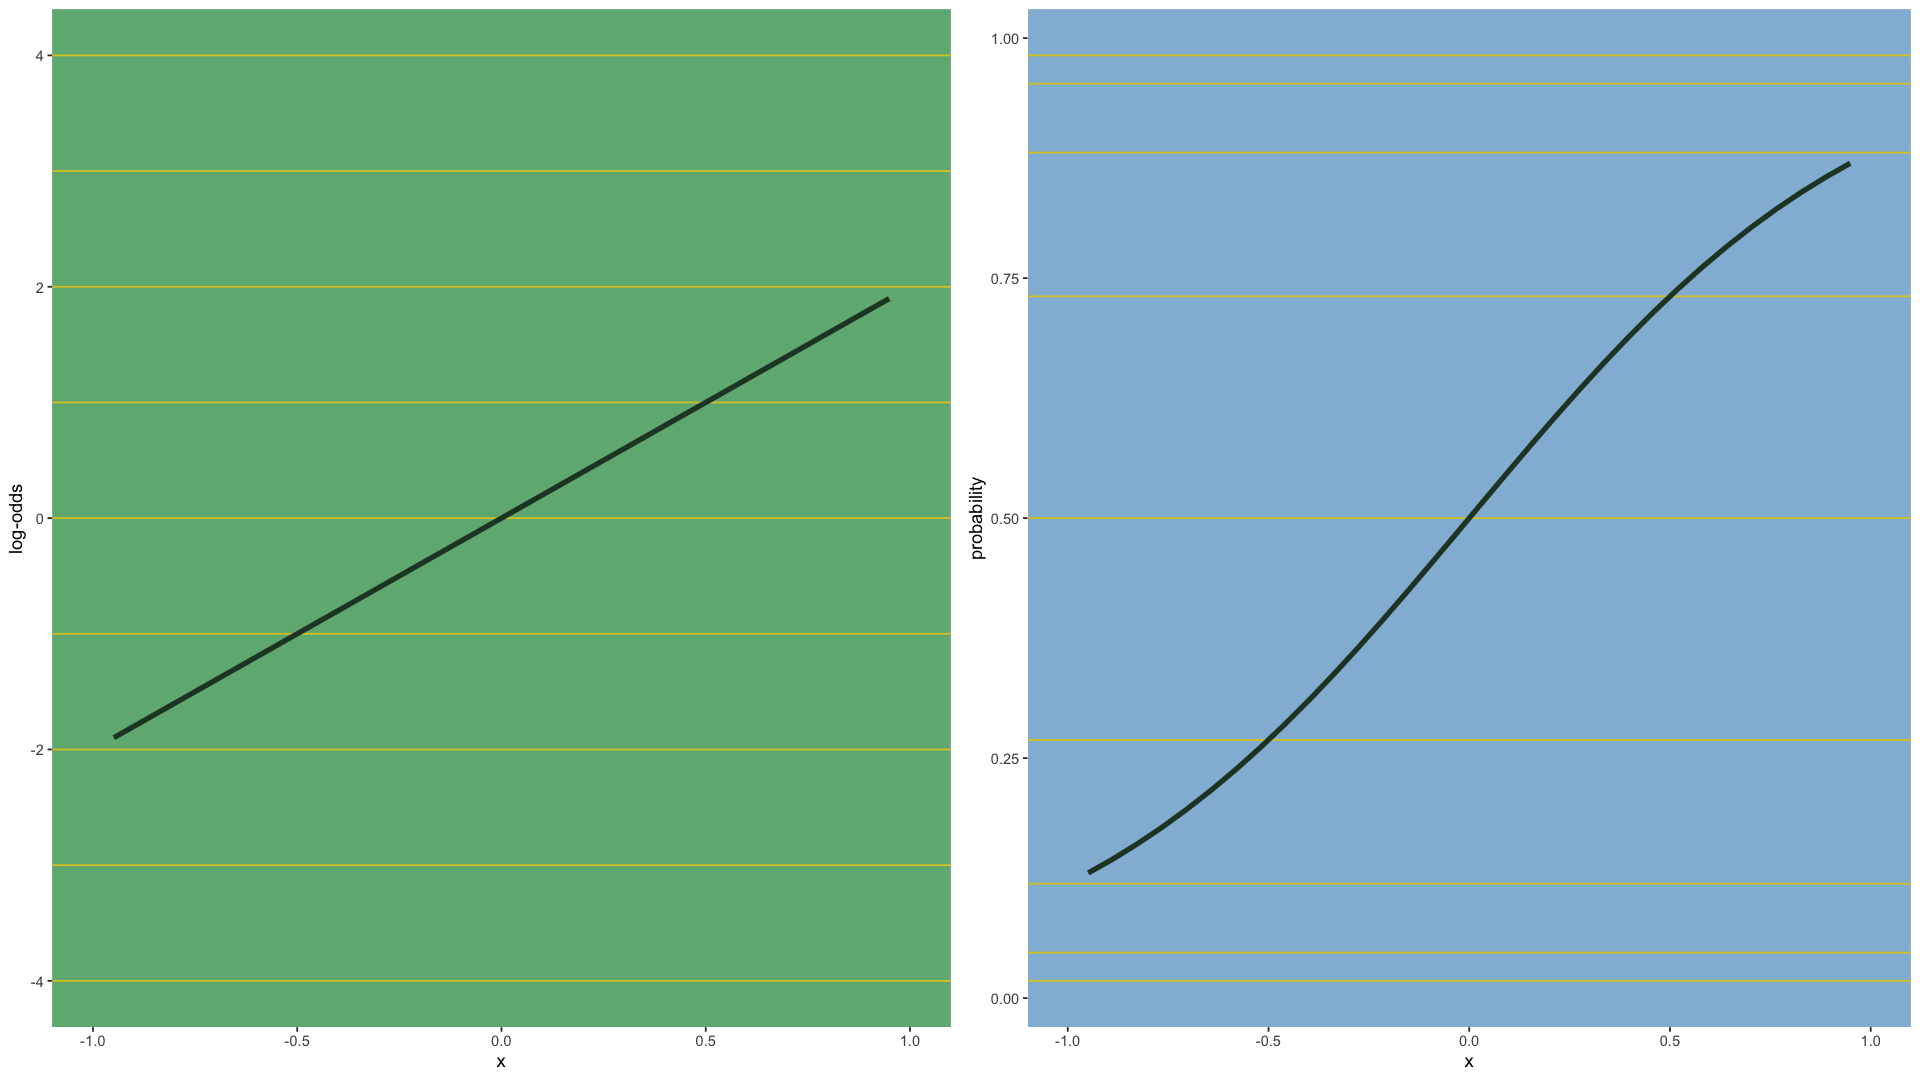

In [32]:
# first, we'll make data for the horizontal lines
alpha <- 0
beta  <- 4

lines <-
  tibble(x           = seq(from = -1, to = 1, by = .25)) %>% 
  mutate(`log-odds`  = alpha + x * beta,
         probability = exp(alpha + x * beta) / (1 + exp(alpha + x * beta)))

# now we're ready to make the primary data
beta  <- 2

d <-
  tibble(x           = seq(from = -1.5, to = 1.5, length.out = 50)) %>% 
  mutate(`log-odds`  = alpha + x * beta,
         probability = exp(alpha + x * beta) / (1 + exp(alpha + x * beta))) 

# now we make the individual plots
p1 <-
  d %>% 
  ggplot(aes(x = x, y = `log-odds`)) +
  geom_hline(data = lines,
             aes(yintercept = `log-odds`),
             color = ghibli_palette("YesterdayMedium")[6]) +
  geom_line(size = 1.5, color = ghibli_palette("YesterdayMedium")[3]) +
  scale_x_continuous(limits = c(-1, 1)) +
  theme(panel.grid = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("YesterdayMedium")[5]))

p2 <-
  d %>% 
  ggplot(aes(x = x, y = probability)) +
  geom_hline(data = lines,
             aes(yintercept = probability),
             color = ghibli_palette("YesterdayMedium")[6]) +
  geom_line(size = 1.5, color = ghibli_palette("YesterdayMedium")[3]) +
  scale_x_continuous(limits = c(-1, 1)) +
  theme(panel.grid = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("YesterdayMedium")[7]))

# finally, we're ready to mash the plots together and behold their nerdy glory
library(gridExtra)

grid.arrange(p1, p2, ncol = 2)

In [33]:
set.seed(9)
(
  d <-
  tibble(x = rep(0:1, each = 100)) %>% 
  mutate(y = rnorm(n = n(), mean = 100, sd = 10 + x * 10))
  )

x,y
<int>,<dbl>
0,92.33204
0,91.83542
0,98.58465
0,97.22395
0,104.36307
0,88.13127
0,111.91987
0,99.81810
0,97.51915


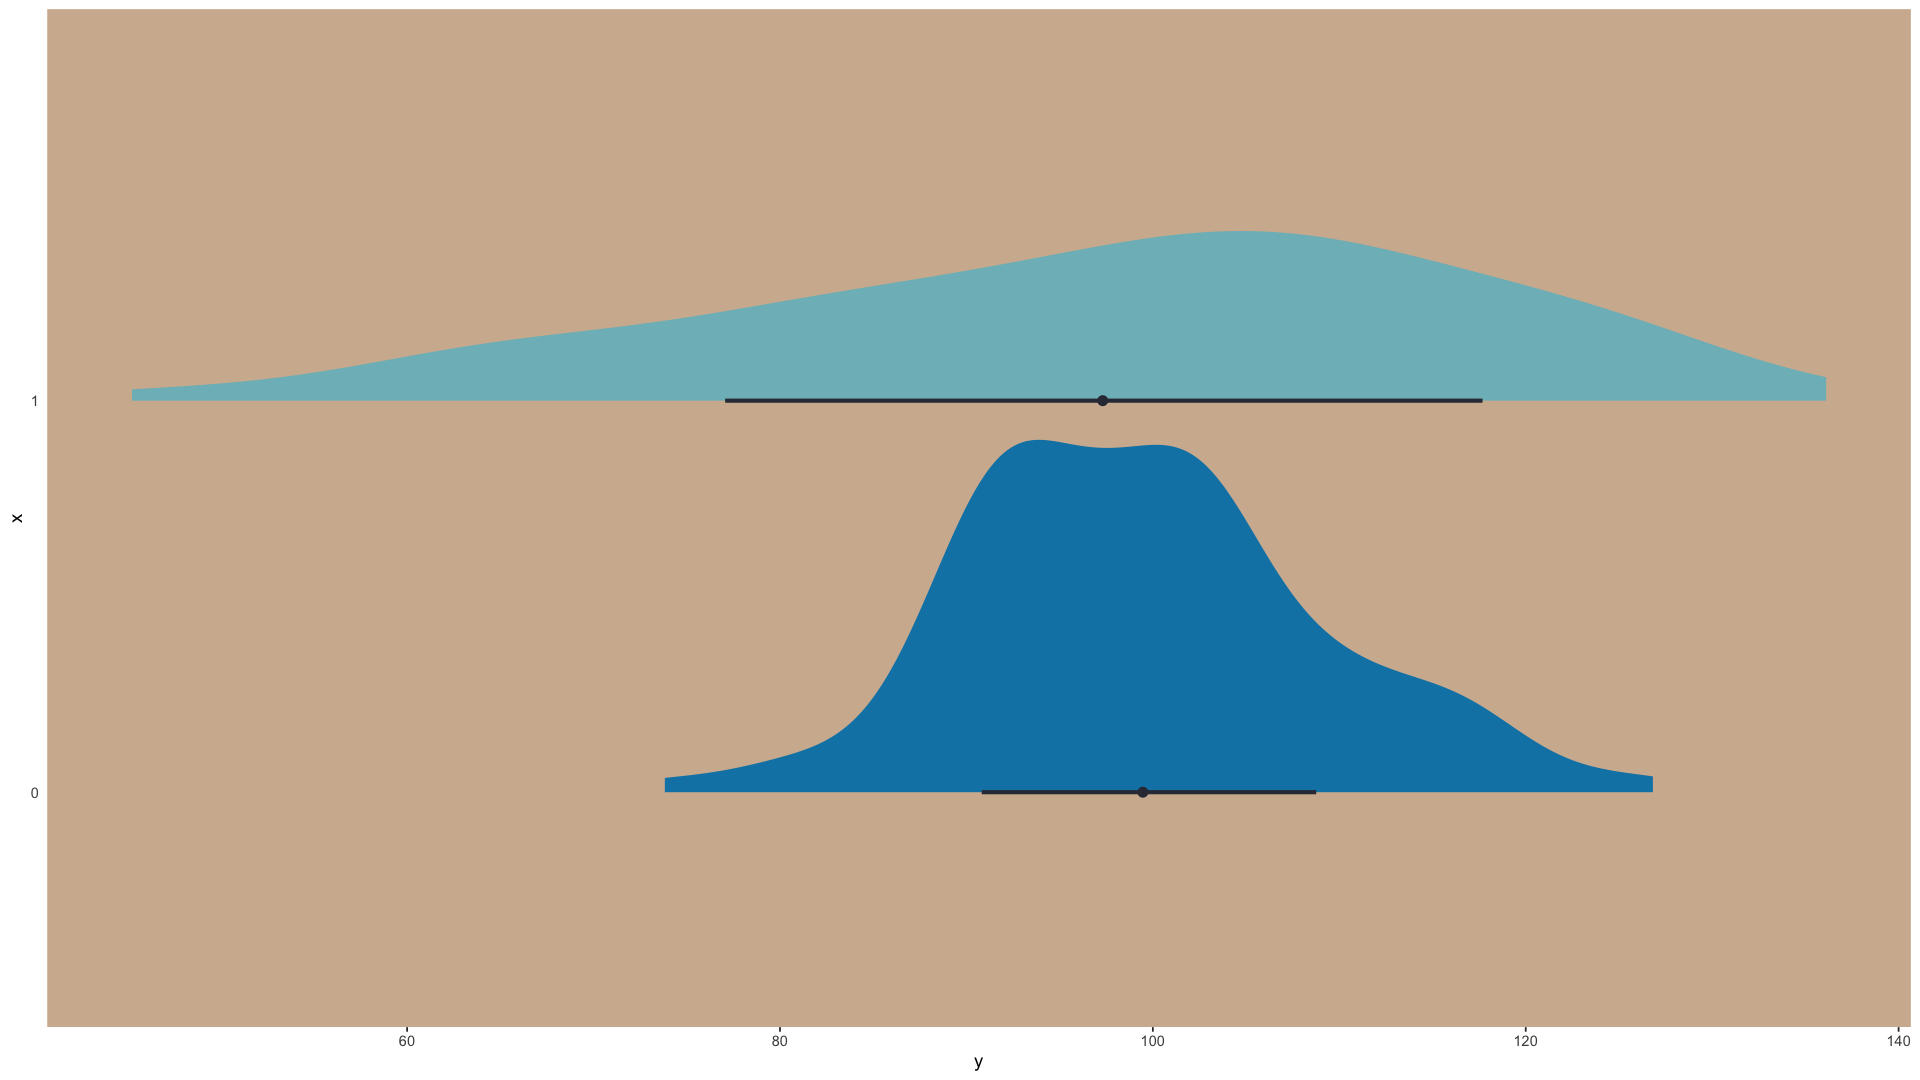

In [34]:
library(tidybayes)

d %>% 
  mutate(x = x %>% as.character()) %>% 
  
  ggplot(aes(x = y, y = x, fill = x)) +
  geom_halfeyeh(color = ghibli_palette("KikiMedium")[2],
                point_interval = mean_qi, .width = .68) +
  scale_fill_manual(values = c(ghibli_palette("KikiMedium")[4],
                                   ghibli_palette("KikiMedium")[6])) +
  theme(panel.grid       = element_blank(),
        axis.ticks.y     = element_blank(),
        legend.position  = "none",
        panel.background = element_rect(fill = ghibli_palette("KikiMedium")[7]))

即使`y`两个`x`虚拟对象的均值均相同，x == 1的方差也明显大于x == 0的方差

In [35]:
library(brms)
b9.1 <- 
  brm(data = d,
      family = gaussian,
      bf(y ~ 1, sigma ~ 1 + x),
      prior = c(prior(normal(100, 10), class = Intercept),
                prior(normal(0, 10),   class = Intercept, dpar = sigma),
                prior(normal(0, 10),   class = b,         dpar = sigma)),
      seed = 9)
print(b9.1)

Loading required package: Rcpp

Loading 'brms' package (version 2.12.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '6ba36fab5a8e0feb7e8b1d25d43a6748' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 6.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.134719 seconds (Warm-up)
Chain 1:                0.105819 seconds (Sampling)


In [39]:
post <- posterior_samples(b9.1)

head(post)

,b_Intercept,b_sigma_Intercept,b_sigma_x,lp__
,<dbl>,<dbl>,<dbl>,<dbl>
1,98.84956,2.233535,0.8623039,-818.6777
2,100.14612,2.266612,0.6808733,-818.3497
3,99.92042,2.288555,0.5394581,-820.7937
4,98.53169,2.252506,0.8204850,-818.3785
5,99.33601,2.316855,0.8825084,-821.8363
6,97.89674,2.327657,0.8140927,-821.0064


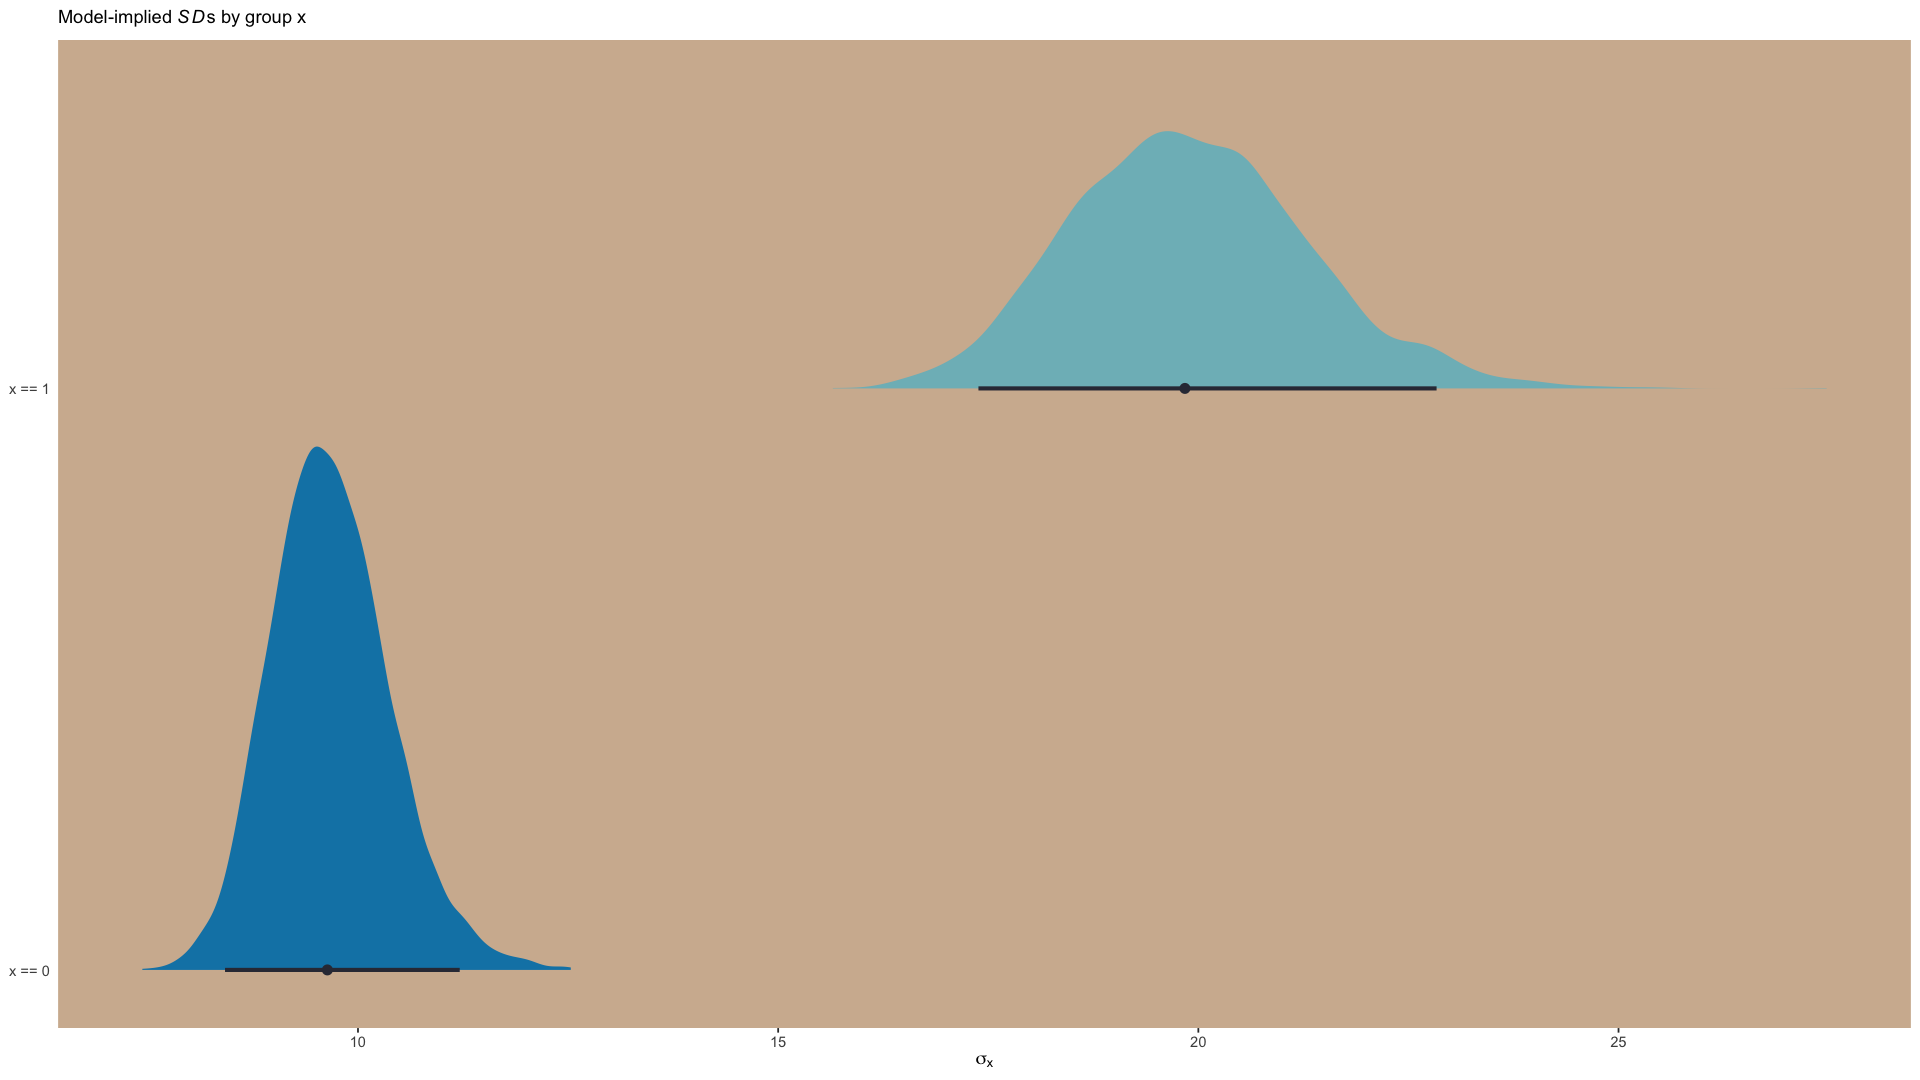

In [41]:
post %>% 
  transmute(`x == 0` = exp(b_sigma_Intercept + b_sigma_x * 0),
            `x == 1` = exp(b_sigma_Intercept + b_sigma_x * 1)) %>% 
  gather(key, sd) %>% 
  
  ggplot(aes(x = sd, y = key, fill = key)) +
  geom_halfeyeh(color = ghibli_palette("KikiMedium")[2],
                point_interval = median_qi, .width = .95) +
  scale_fill_manual(values = c(ghibli_palette("KikiMedium")[4],
                                   ghibli_palette("KikiMedium")[6])) +
  labs(x = expression(sigma[x]), y = NULL,
       subtitle = expression(paste("Model-implied ", italic(SD), "s by group x"))) +
        coord_cartesian(ylim = c(1.5, 2)) +
  theme(panel.grid       = element_blank(),
        axis.ticks.y     = element_blank(),
        legend.position  = "none",
        panel.background = element_rect(fill = ghibli_palette("KikiMedium")[7]))

In [42]:
d %>% 
  group_by(x) %>% 
  summarise(sd = sd(y) %>% round(digits = 1)) 

x,sd
<int>,<dbl>
0,9.6
1,19.8


### log

Warning message:
“Removed 18 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_hline).”
Warning message:
“Removed 18 row(s) containing missing values (geom_path).”


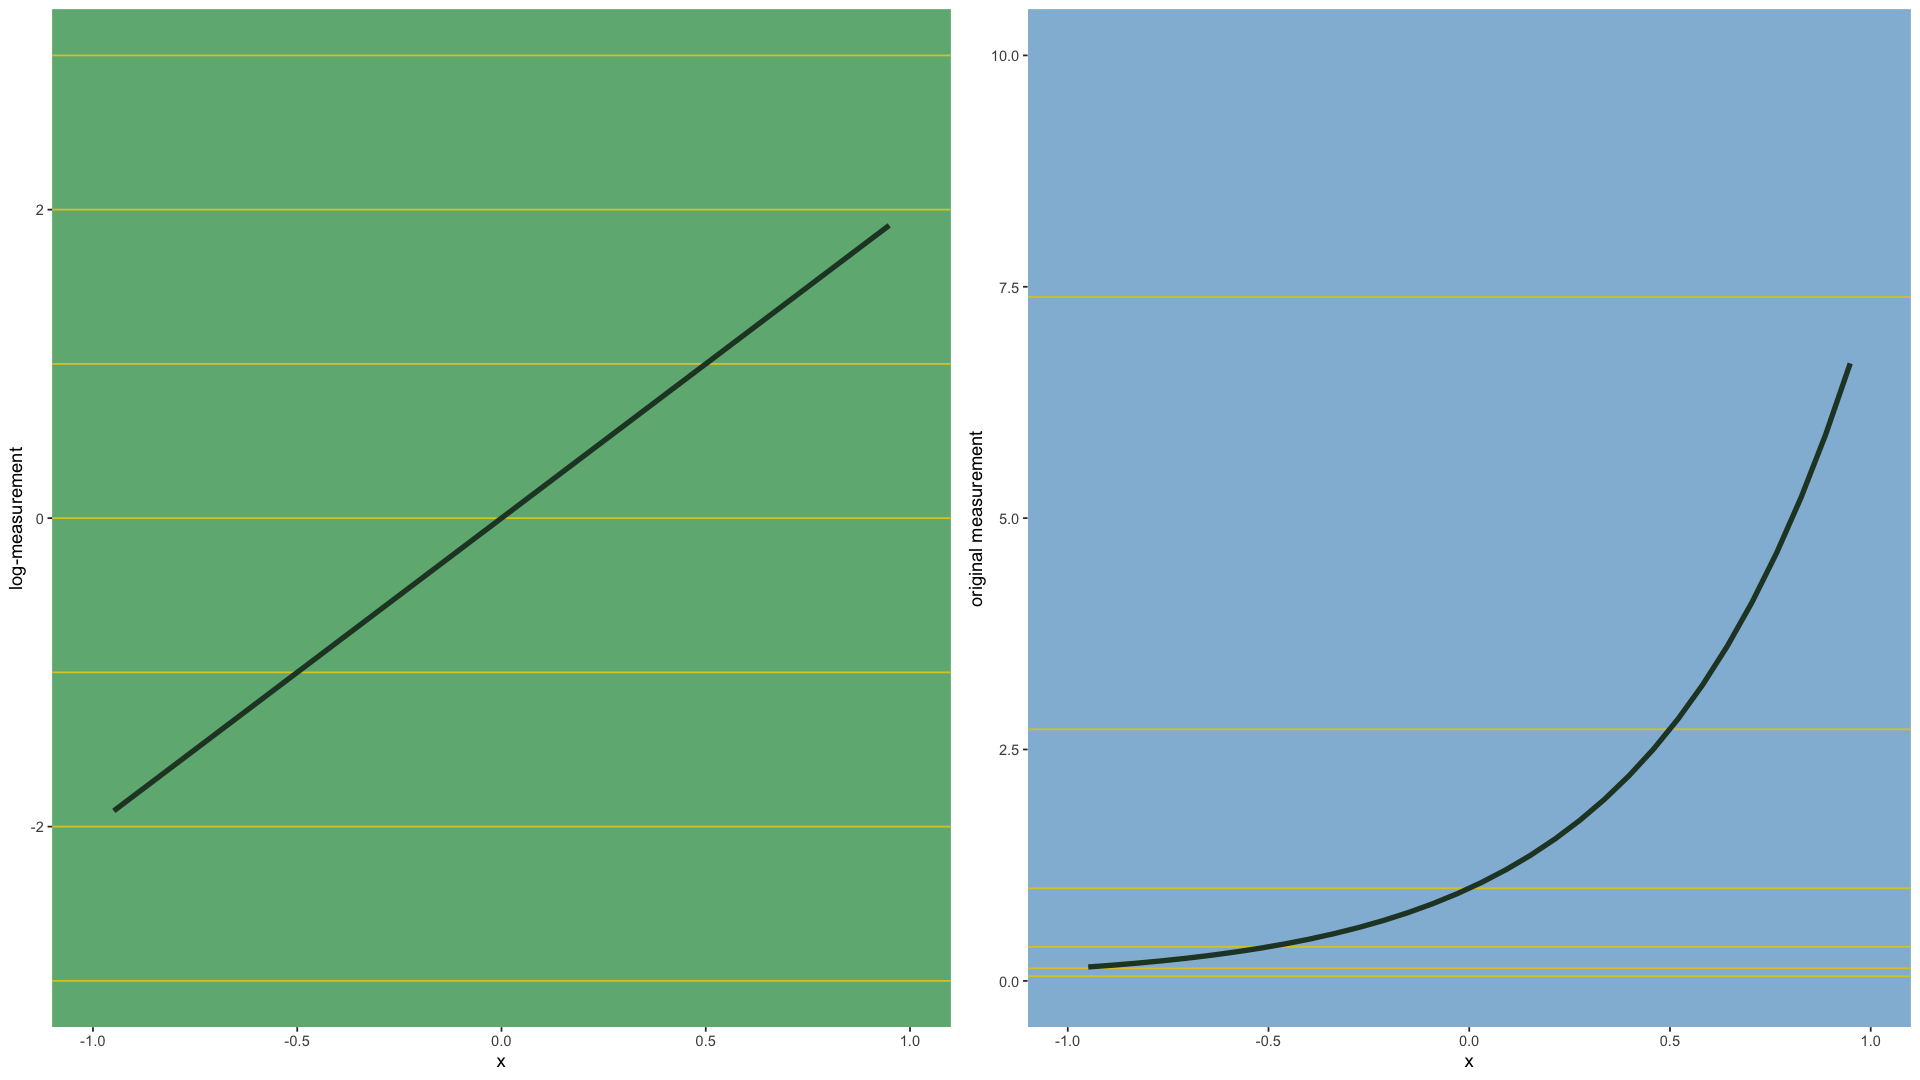

In [45]:
# first, we'll make data that'll be make the horizontal lines
alpha <- 0
beta  <- 2

lines <-
  tibble(`log-measurement`      = -3:3) %>% 
  mutate(`original measurement` = exp(`log-measurement`))

# now we're ready to make the primary data
d <-
  tibble(x                      = seq(from = -1.5, to = 1.5, length.out = 50)) %>% 
  mutate(`log-measurement`      = alpha + x * beta,
         `original measurement` = exp(alpha + x * beta)) 

# now we make the individual plots
p1 <-
  d %>% 
  ggplot(aes(x = x, y = `log-measurement`)) +
  geom_hline(data = lines,
             aes(yintercept = `log-measurement`),
             color = ghibli_palette("YesterdayMedium")[6]) +
  geom_line(size = 1.5, color = ghibli_palette("YesterdayMedium")[3]) +
  scale_x_continuous(limits = c(-1, 1)) +
  theme(panel.grid = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("YesterdayMedium")[5]))

p2 <-
  d %>% 
  ggplot(aes(x = x, y = `original measurement`)) +
  geom_hline(data = lines,
             aes(yintercept = `original measurement`),
             color = ghibli_palette("YesterdayMedium")[6]) +
  geom_line(size = 1.5, color = ghibli_palette("YesterdayMedium")[3]) +
  scale_x_continuous(limits = c(-1, 1)) +
  scale_y_continuous(limits = c(0, 10)) +
  theme(panel.grid = element_blank(),
        panel.background = element_rect(fill = ghibli_palette("YesterdayMedium")[7]))

# finally, we're ready to mash the plots together and behold their nerdy glory
grid.arrange(p1, p2, ncol = 2)

In [46]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Catalina 10.15.3

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

locale:
[1] zh_CN.UTF-8/zh_CN.UTF-8/zh_CN.UTF-8/C/zh_CN.UTF-8/zh_CN.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] brms_2.12.0     Rcpp_1.0.3      tidybayes_2.0.1 gridExtra_2.3  
 [5] forcats_0.5.0   stringr_1.4.0   dplyr_0.8.4     purrr_0.3.3    
 [9] readr_1.3.1     tidyr_1.0.2     tibble_2.1.3    ggplot2_3.3.0  
[13] tidyverse_1.3.0 ghibli_0.3.1    repr_1.1.0     

loaded via a namespace (and not attached):
  [1] colorspace_1.4-1     ellipsis_0.3.0       ggridges_0.5.2      
  [4] rsconnect_0.8.16     IRdisplay_0.7.0      markdown_1.1        
  [7] base64enc_0.1-3      fs_1.3.2             rstu